In [1]:
# Section 1: Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path
import os
from sklearn.model_selection import train_test_split
import gdown
import zipfile
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical


In [2]:
# Download the entire Classification dataset as a zip file
url = "https://drive.google.com/file/d/1YW3f1IxXVHjTVSK_i3WwwlK5-BbjHAuE/view?usp=sharing"  # Direct link to the Google Drive file
output = "/content/classification.zip"

# Use gdown to download the file
gdown.download(url=url, output=output, fuzzy=True)

# Extract the downloaded zip file
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('/content/')



Downloading...
From (original): https://drive.google.com/uc?id=1YW3f1IxXVHjTVSK_i3WwwlK5-BbjHAuE
From (redirected): https://drive.google.com/uc?id=1YW3f1IxXVHjTVSK_i3WwwlK5-BbjHAuE&confirm=t&uuid=c61f545a-059f-40ce-8300-a4fef7aa912a
To: /content/classification.zip
100%|██████████| 369M/369M [00:03<00:00, 96.5MB/s]


In [3]:
  # Step 2: Load and Understand Annotations
  def load_annotations(csv_path):
      return pd.read_csv(csv_path, sep=';')

  train_annotations = load_annotations('/content/classification/data/train/Final_Training/GT_Train.csv')
  test_annotations = load_annotations('/content/classification/data/test/GT-final_test.csv')


In [4]:
# Function to preprocess images
def preprocess_image(image_path, bbox):
    if not os.path.exists(image_path):
        print(f"Image path does not exist: {image_path}")
        return None

    image = cv2.imread(image_path)  # or PIL.Image.open(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x1, y1, x2, y2 = bbox
    cropped_image = image[y1:y2, x1:x2]
    resized_image = cv2.resize(cropped_image, (32, 32))  # Resize to 32x32
    normalized_image = resized_image / 255.0  # Normalize pixel values
    return normalized_image

In [5]:

# Correct the function to load images and labels for training data
def load_train_images_and_labels(annotations, base_path):
    images = []
    labels = []
    for _, row in annotations.iterrows():
        class_id = f"{row['ClassId']:05d}"
        filename = row['Filename']
        # Construct the correct image path
        image_path = os.path.join(base_path, class_id, filename)
        bbox = (row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2'])
        label = row['ClassId']
        preprocessed_image = preprocess_image(image_path, bbox)
        if preprocessed_image is not None:
            images.append(preprocessed_image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Function to load images and labels for test data
def load_test_images_and_labels(annotations, base_path):
    images = []
    labels = []
    for _, row in annotations.iterrows():
        filename = row['Filename']
        image_path = os.path.join(base_path, filename)
        bbox = (row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2'])
        preprocessed_image = preprocess_image(image_path, bbox)
        if preprocessed_image is not None:
            images.append(preprocessed_image)
            labels.append(row['ClassId'])
    return np.array(images), np.array(labels)

# Ensure the paths to annotations are correct
print("Train Annotations Head:\n", train_annotations.head())
print("Test Annotations Head:\n", test_annotations.head())

Train Annotations Head:
           Filename  Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId
0  00000_00000.ppm     26      26       5       5      20      21       33
1  00000_00001.ppm     27      28       5       6      22      23       33
2  00000_00002.ppm     27      27       5       5      22      21       33
3  00000_00003.ppm     28      27       6       5      23      22       33
4  00000_00004.ppm     27      29       5       6      22      24       33
Test Annotations Head:
     Filename  Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId
0  00000.ppm     53      54       6       5      48      49       16
1  00001.ppm     42      45       5       5      36      40        1
2  00002.ppm     48      52       6       6      43      47       38
3  00003.ppm     27      29       5       5      22      24       33
4  00004.ppm     60      57       5       5      55      52       11


In [6]:
# Load images and labels
train_images, train_labels = load_train_images_and_labels(train_annotations, '/content/classification/data/train/Final_Training/Images')
test_images, test_labels = load_test_images_and_labels(test_annotations, '/content/classification/data/test/Final_Test/Images')


In [7]:
# Prepare data for training
num_classes = train_annotations['ClassId'].nunique()
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)



In [8]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=99)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).shuffle(buffer_size=1024)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32)

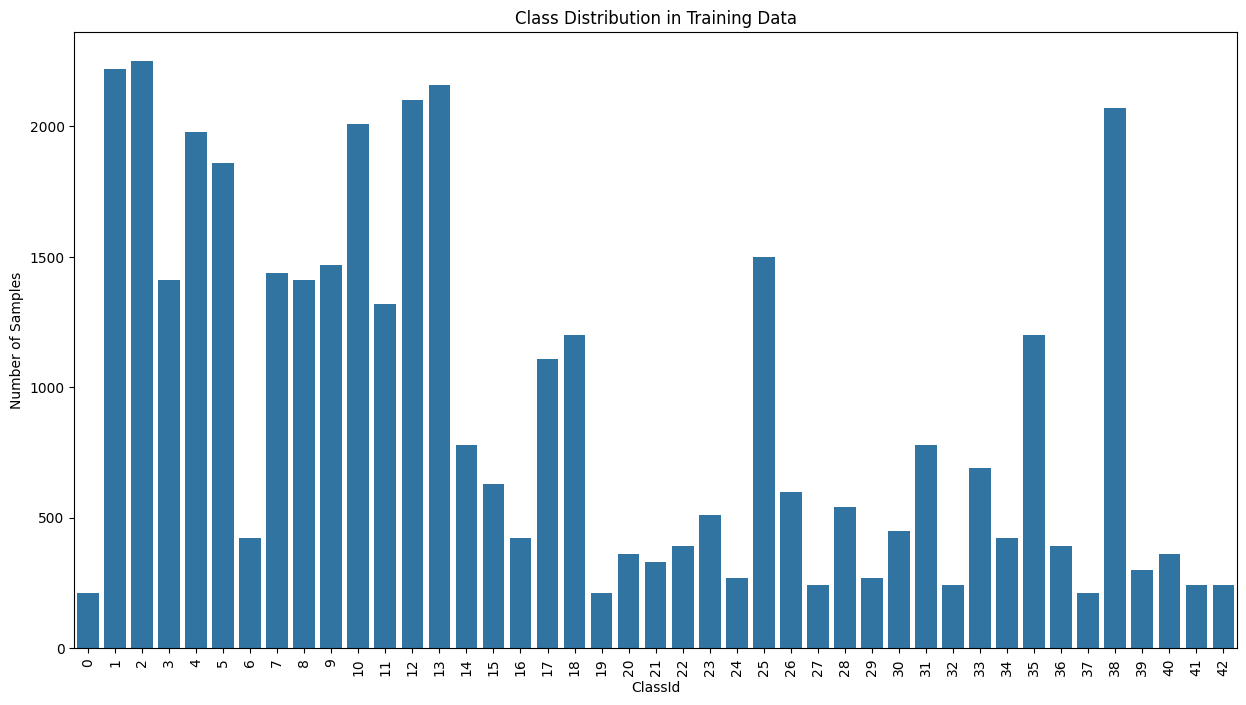

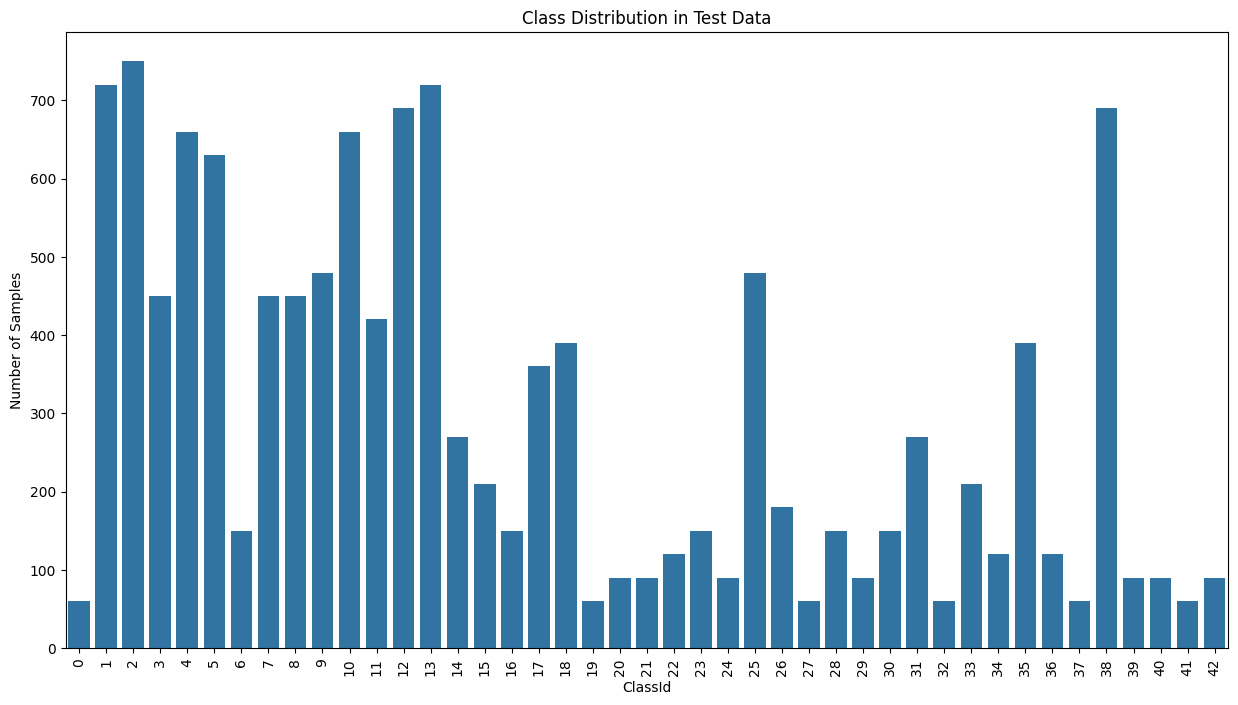

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot class distribution for training data
plt.figure(figsize=(15, 8))
sns.countplot(x=train_annotations['ClassId'])
plt.title('Class Distribution in Training Data')
plt.xlabel('ClassId')
plt.ylabel('Number of Samples')
plt.xticks(rotation=90)
plt.show()

# Plot class distribution for test data
plt.figure(figsize=(15, 8))
sns.countplot(x=test_annotations['ClassId'])
plt.title('Class Distribution in Test Data')
plt.xlabel('ClassId')
plt.ylabel('Number of Samples')
plt.xticks(rotation=90)
plt.show()


In [12]:
import pandas as pd

def summarize_dataset(train_annotations, test_annotations):
    # Summarize the total number of images
    total_images_train = len(train_annotations)
    total_images_test = len(test_annotations)
    total_images = total_images_train + total_images_test

    # Count the number of images per class for both sets
    train_class_distribution = train_annotations['ClassId'].value_counts().sort_index()
    test_class_distribution = test_annotations['ClassId'].value_counts().sort_index()

    # Print out the summaries
    print(f"Total number of images in dataset: {total_images}")
    print(f"Number of images in training set: {total_images_train}")
    print(f"Number of images in test set: {total_images_test}")
    print("\nDistribution of images per class in training set:")
    print(train_class_distribution)
    print("\nDistribution of images per class in test set:")
    print(test_class_distribution)

# Example usage (assuming you've already loaded train_annotations and test_annotations as per the previous code):
summarize_dataset(train_annotations, test_annotations)


Total number of images in dataset: 51839
Number of images in training set: 39209
Number of images in test set: 12630

Distribution of images per class in training set:
ClassId
0      210
1     2220
2     2250
3     1410
4     1980
5     1860
6      420
7     1440
8     1410
9     1470
10    2010
11    1320
12    2100
13    2160
14     780
15     630
16     420
17    1110
18    1200
19     210
20     360
21     330
22     390
23     510
24     270
25    1500
26     600
27     240
28     540
29     270
30     450
31     780
32     240
33     689
34     420
35    1200
36     390
37     210
38    2070
39     300
40     360
41     240
42     240
Name: count, dtype: int64

Distribution of images per class in test set:
ClassId
0      60
1     720
2     750
3     450
4     660
5     630
6     150
7     450
8     450
9     480
10    660
11    420
12    690
13    720
14    270
15    210
16    150
17    360
18    390
19     60
20     90
21     90
22    120
23    150
24     90
25    480
26    180


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)


In [ ]:
# Define early stopping and model checkpoint callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=75,
    callbacks=callbacks
)

Epoch 1/75
981/981 [==============================] - 11s 10ms/step - loss: 1.6390 - accuracy: 0.5354 - val_loss: 0.3738 - val_accuracy: 0.9141
Epoch 2/75


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


981/981 [==============================] - 10s 10ms/step - loss: 0.5225 - accuracy: 0.8403 - val_loss: 0.1478 - val_accuracy: 0.9705
Epoch 3/75
981/981 [==============================] - 10s 10ms/step - loss: 0.3385 - accuracy: 0.8984 - val_loss: 0.0904 - val_accuracy: 0.9813
Epoch 4/75
981/981 [==============================] - 10s 10ms/step - loss: 0.2548 - accuracy: 0.9234 - val_loss: 0.0759 - val_accuracy: 0.9837
Epoch 5/75
981/981 [==============================] - 10s 10ms/step - loss: 0.2170 - accuracy: 0.9317 - val_loss: 0.0586 - val_accuracy: 0.9871
Epoch 6/75
981/981 [==============================] - 10s 10ms/step - loss: 0.1840 - accuracy: 0.9424 - val_loss: 0.0527 - val_accuracy: 0.9867
Epoch 7/75
981/981 [==============================] - 10s 10ms/step - loss: 0.1627 - accuracy: 0.9494 - val_loss: 0.0450 - val_accuracy: 0.9895
Epoch 8/75
981/981 [==============================] - 10s 10ms/step - loss: 0.1476 - accuracy: 0.9528 - val_loss: 0.0391 - val_accuracy: 0.9913
Epo

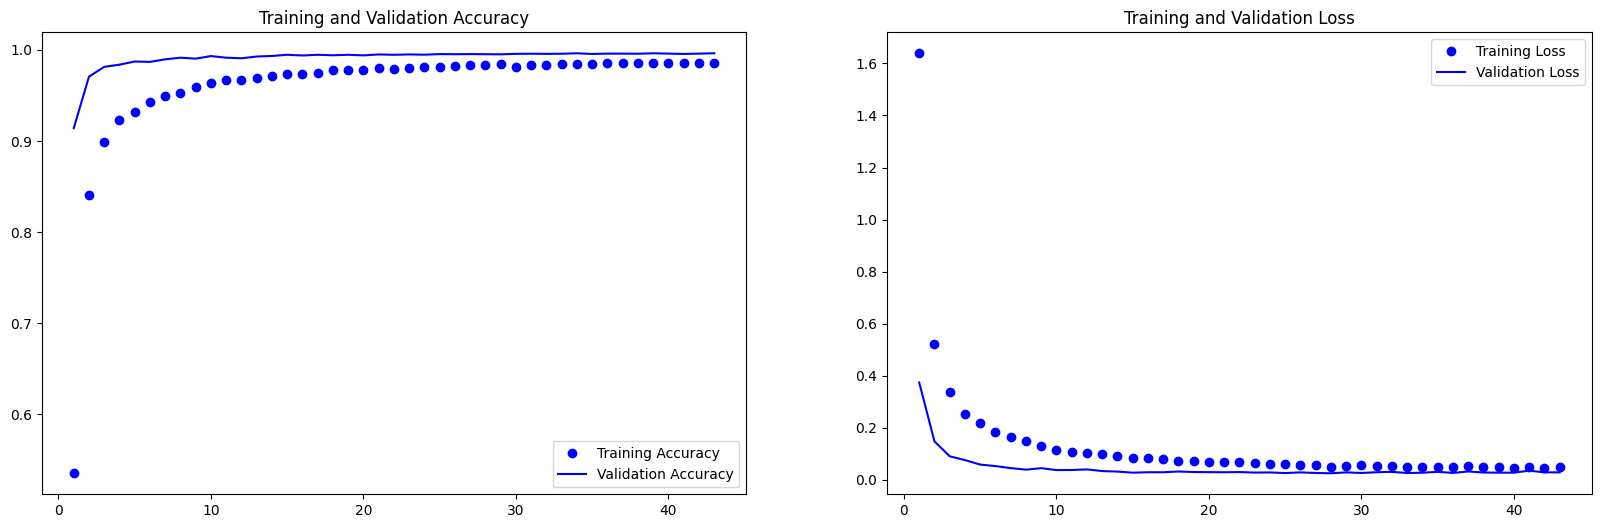

In [ ]:
# Function to plot the training and validation metrics
import matplotlib.pyplot as plt

def plot_metrics(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, "bo", label="Training Accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "bo", label="Training Loss")
    plt.plot(epochs, val_loss, "b", label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    plt.show()

# Plot the metrics
plot_metrics(history)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Predict on the test set
y_test_pred = model.predict(test_dataset)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true = np.argmax(test_labels, axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(y_test_true, y_test_pred_classes)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Generate classification report
class_report = classification_report(y_test_true, y_test_pred_classes)
print('Classification Report:')
print(class_report)



395/395 [==============================] - 1s 3ms/step
Test Accuracy: 0.9717
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.98      0.99      0.98       720
           2       0.98      0.99      0.98       750
           3       0.97      0.95      0.96       450
           4       1.00      0.97      0.99       660
           5       0.89      0.99      0.94       630
           6       1.00      0.73      0.84       150
           7       0.99      0.94      0.96       450
           8       0.98      0.97      0.97       450
           9       0.93      1.00      0.96       480
          10       1.00      0.99      0.99       660
          11       0.96      0.98      0.97       420
          12       1.00      0.99      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       1.00      1.00  

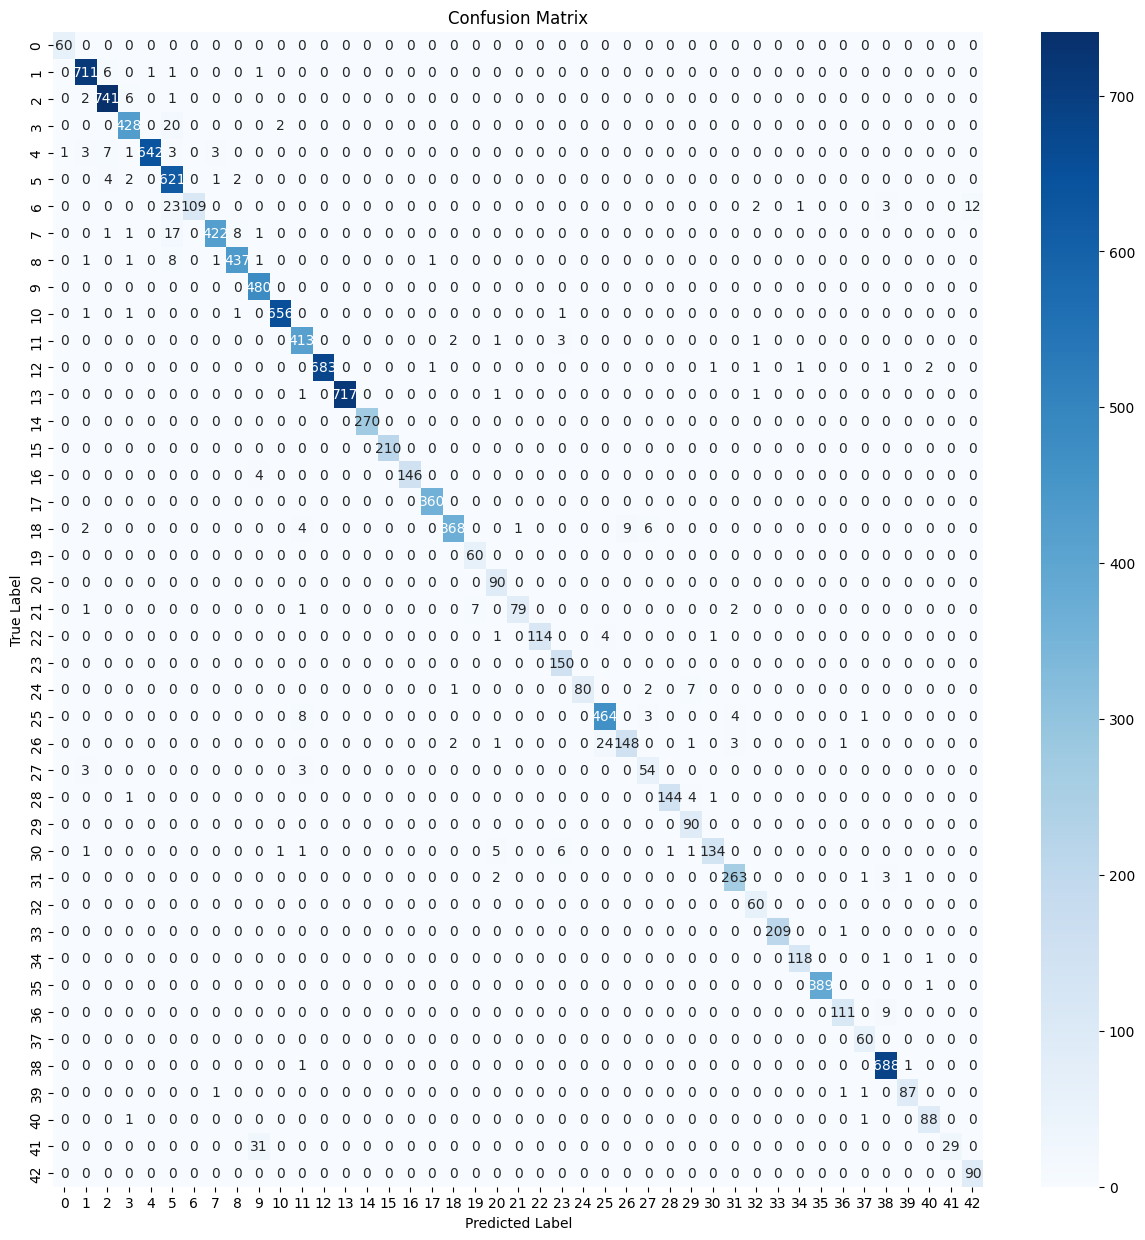

In [ ]:
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_true, y_test_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


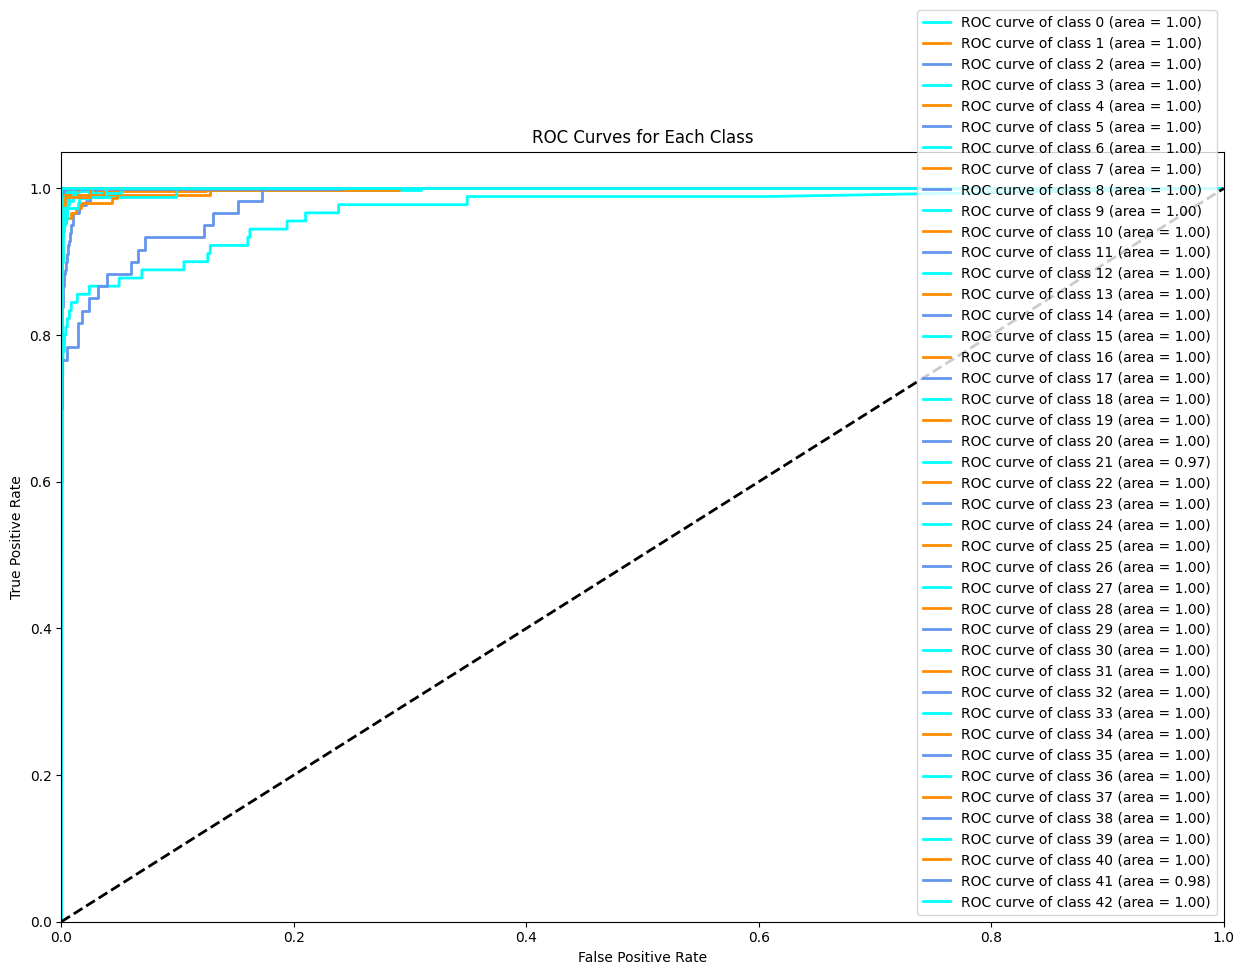

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the output labels
y_test_binarized = label_binarize(y_test_true, classes=range(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_test_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(15, 10))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()


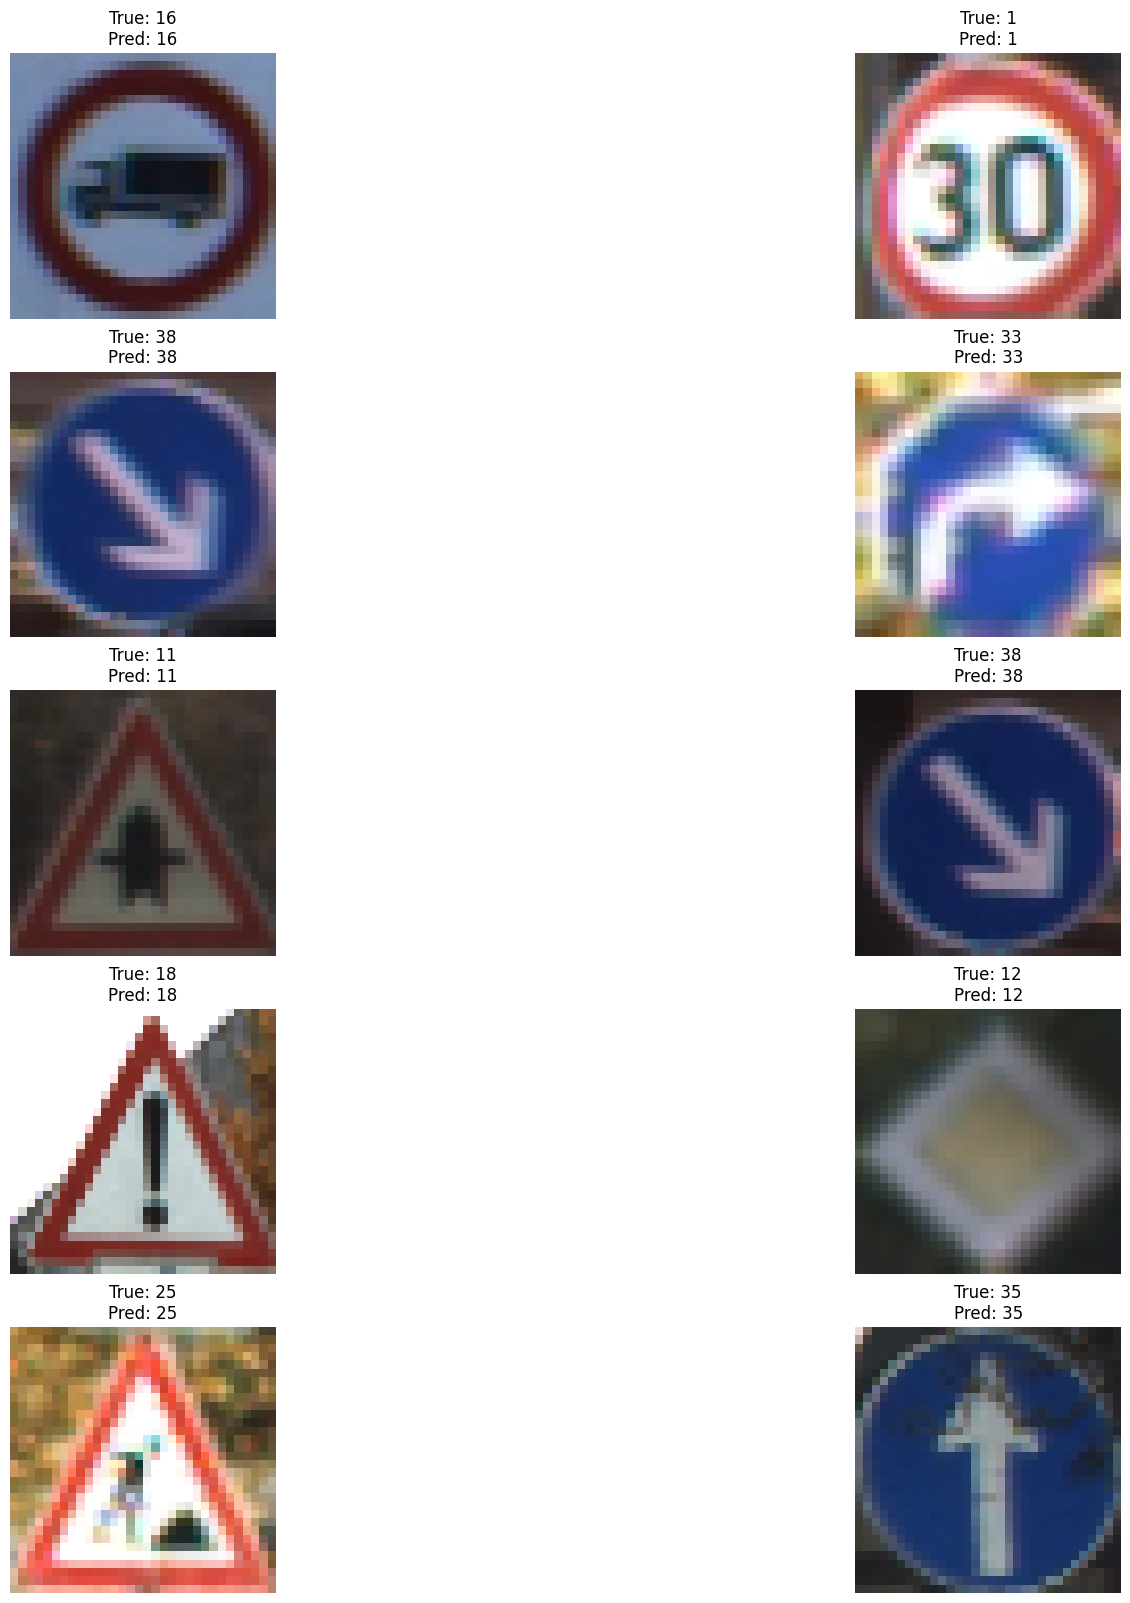

In [ ]:
def show_images_with_predictions(images, true_labels, pred_labels, class_names, num_images=10):
    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        plt.subplot(5, 2, i + 1)
        plt.imshow(images[i])
        true_class = class_names[true_labels[i]]
        pred_class = class_names[pred_labels[i]]
        plt.title(f'True: {true_class}\nPred: {pred_class}')
        plt.axis('off')
    plt.show()

# Prepare data for visualization
# As the dataset is batched, we need to convert it back to arrays for visualization
test_images_list = list(test_dataset.as_numpy_iterator())
test_images = np.concatenate([batch[0] for batch in test_images_list])
test_labels = np.concatenate([batch[1] for batch in test_images_list])

# Class names (replace with your actual class names if you have them)
class_names = [str(i) for i in range(num_classes)]

# Show images with predictions
show_images_with_predictions(test_images, y_test_true, y_test_pred_classes, class_names)


#Test modelo LeNet5

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense

# Define the LeNet-5 model
lenet_model = Sequential([
    Conv2D(6, (5, 5), activation='tanh', input_shape=(32, 32, 3), padding='same'),
    AveragePooling2D((2, 2), strides=2),

    Conv2D(16, (5, 5), activation='tanh', padding='same'),
    AveragePooling2D((2, 2), strides=2),

    Flatten(),
    Dense(120, activation='tanh'),
    Dense(84, activation='tanh'),
    Dense(num_classes, activation='softmax')
])

# Compile the LeNet-5 model
lenet_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)


In [ ]:
# Define early stopping and model checkpoint callbacks
lenet_callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint('best_lenet_model.h5', save_best_only=True)
]

# Train the LeNet-5 model
lenet_history = lenet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=lenet_callbacks
)


In [ ]:
# Predict on the test set
y_test_pred_lenet = lenet_model.predict(test_dataset)
y_test_pred_classes_lenet = np.argmax(y_test_pred_lenet, axis=1)


395/395 [==============================] - 6s 15ms/step


In [ ]:
# Calculate accuracy for LeNet-5 model
test_accuracy_lenet = accuracy_score(y_test_true, y_test_pred_classes_lenet)
print(f'Test Accuracy (LeNet-5): {test_accuracy_lenet:.4f}')

# Generate classification report for LeNet-5 model
class_report_lenet = classification_report(y_test_true, y_test_pred_classes_lenet)
print('Classification Report (LeNet-5):')
print(class_report_lenet)


Test Accuracy (LeNet-5): 0.9380
Classification Report (LeNet-5):
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        60
           1       0.92      0.96      0.94       720
           2       0.92      0.98      0.95       750
           3       0.97      0.96      0.97       450
           4       0.96      0.95      0.95       660
           5       0.93      0.92      0.92       630
           6       0.99      0.73      0.84       150
           7       0.95      0.89      0.92       450
           8       0.92      0.95      0.93       450
           9       0.99      1.00      0.99       480
          10       0.96      0.98      0.97       660
          11       0.94      0.95      0.95       420
          12       0.96      0.96      0.96       690
          13       0.98      0.99      0.99       720
          14       0.97      0.99      0.98       270
          15       0.96      0.95      0.95       210
          16    

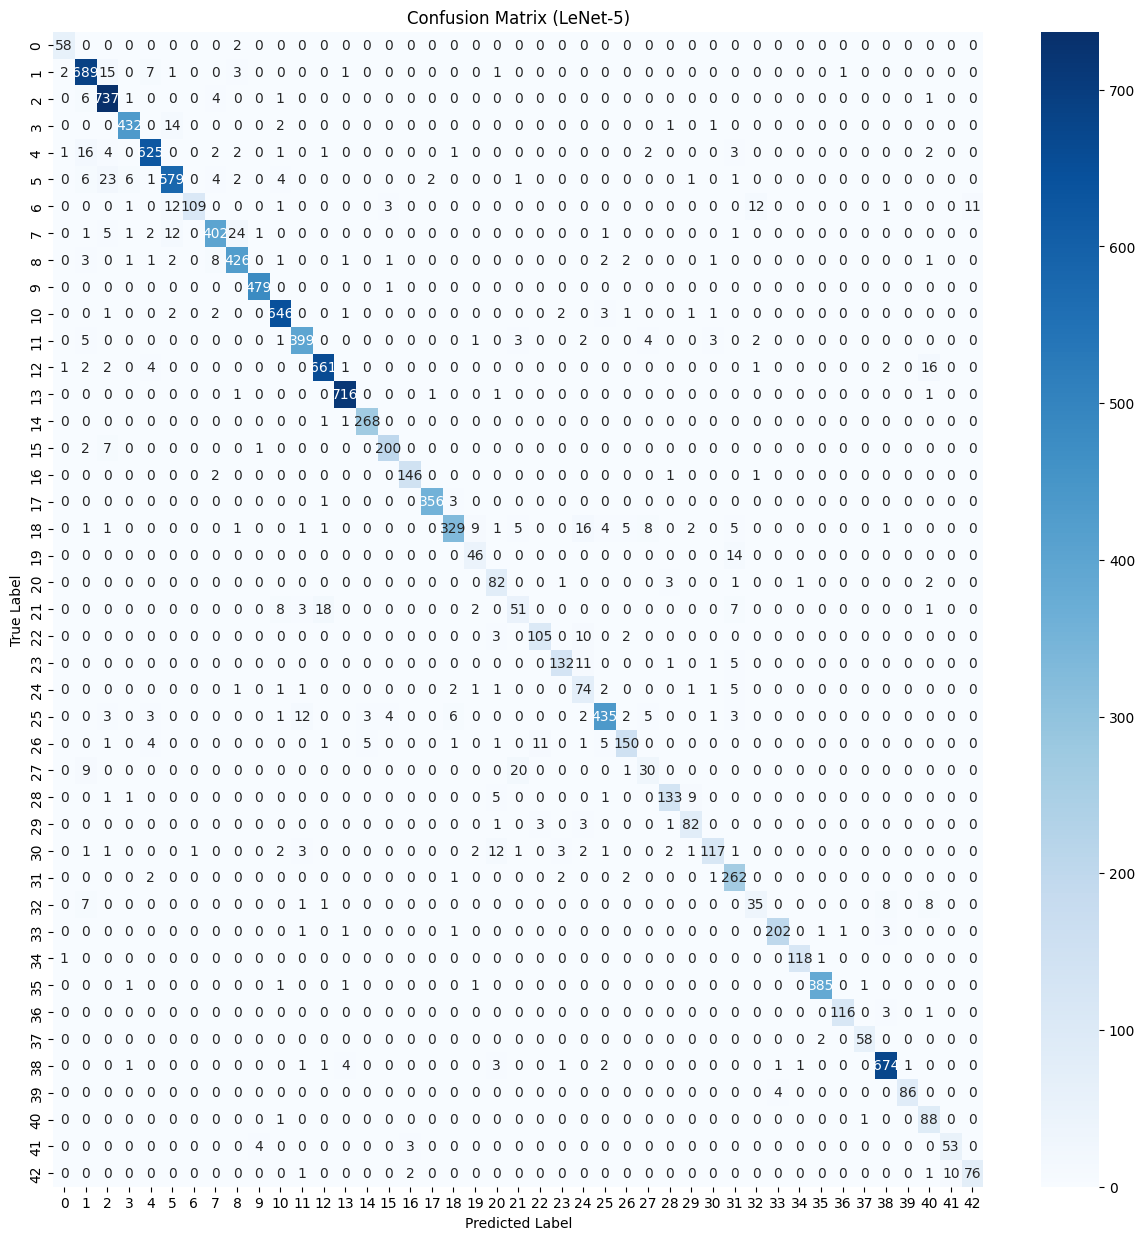

In [ ]:
# Generate confusion matrix for LeNet-5 model
conf_matrix_lenet = confusion_matrix(y_test_true, y_test_pred_classes_lenet)

# Plot confusion matrix for LeNet-5 model
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix_lenet, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Confusion Matrix (LeNet-5)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


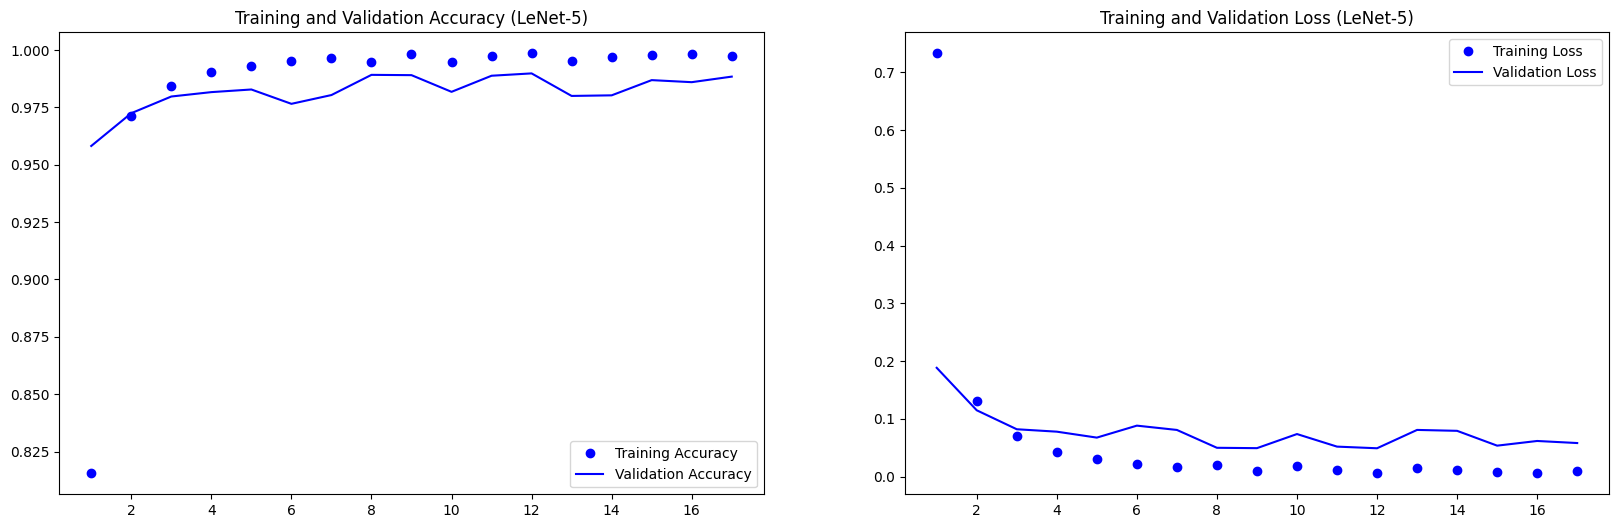

In [ ]:
# Function to plot the training and validation metrics for LeNet-5 model
def plot_lenet_metrics(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, "bo", label="Training Accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
    plt.title("Training and Validation Accuracy (LeNet-5)")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "bo", label="Training Loss")
    plt.plot(epochs, val_loss, "b", label="Validation Loss")
    plt.title("Training and Validation Loss (LeNet-5)")
    plt.legend()

    plt.show()

# Plot the metrics for LeNet-5 model
plot_lenet_metrics(lenet_history)


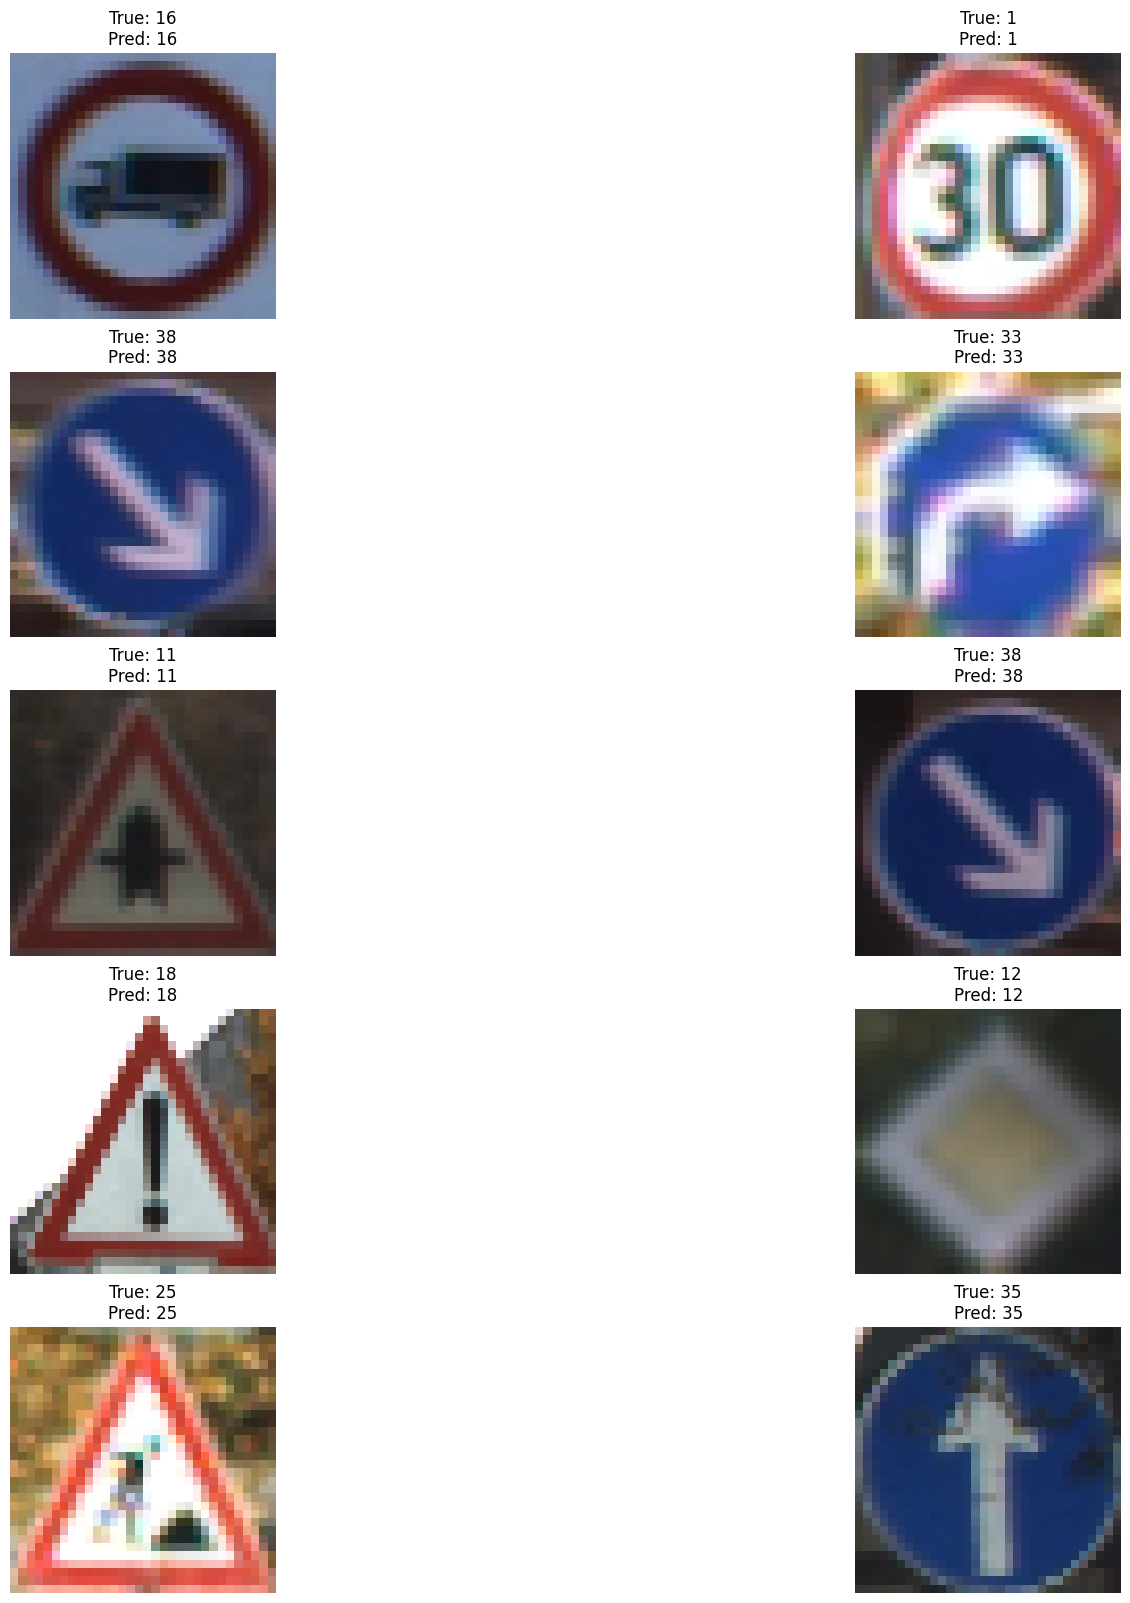

In [ ]:
# Show images with predictions and true classes for LeNet-5 model
show_images_with_predictions(test_images, y_test_true, y_test_pred_classes_lenet, class_names)


In [ ]:
# Dictionary converting the number of CLassID to its actual class.
class_id_to_name = {
    0: 'speed limit 20 (prohibitory)',
    1: 'speed limit 30 (prohibitory)', #IN
    2: 'speed limit 50 (prohibitory)', #IN
    3: 'speed limit 60 (prohibitory)', #IN
    4: 'speed limit 70 (prohibitory)', #IN
    5: 'speed limit 80 (prohibitory)', #IN
    6: 'restriction ends 80 (other)',
    7: 'speed limit 100 (prohibitory)', #IN
    8: 'speed limit 120 (prohibitory)', #IN
    9: 'no overtaking (prohibitory)', #IN
    10: 'no overtaking (trucks) (prohibitory)', #IN
    11: 'priority at next intersection (danger)', #IN
    12: 'priority road (other)', #IN
    13: 'give way (other)', #IN
    14: 'stop (other)', #IN
    15: 'no traffic both ways (prohibitory)',
    16: 'no trucks (prohibitory)',
    17: 'no entry (other)', #IN
    18: 'danger (danger)', #IN
    19: 'bend left (danger)',
    20: 'bend right (danger)',
    21: 'bend (danger)',
    22: 'uneven road (danger)',
    23: 'slippery road (danger)',
    24: 'road narrows (danger)',
    25: 'construction (danger)', #IN
    26: 'traffic signal (danger)',
    27: 'pedestrian crossing (danger)',
    28: 'school crossing (danger)',
    29: 'cycles crossing (danger)',
    30: 'snow (danger)',
    31: 'animals (danger)',
    32: 'restriction ends (other)',
    33: 'go right (mandatory)',
    34: 'go left (mandatory)',
    35: 'go straight (mandatory)',
    36: 'go right or straight (mandatory)',
    37: 'go left or straight (mandatory)',
    38: 'keep right (mandatory)', #IN
    39: 'keep left (mandatory)',
    40: 'roundabout (mandatory)',
    41: 'restriction ends (overtaking) (other)',
    42: 'restriction ends (overtaking (trucks)) (other)'
}

In [ ]:
import pandas as pd

# Calculate TP, FP, FN, TN for each class
def calculate_metrics_per_class(conf_matrix):
    FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
    FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    TP = np.diag(conf_matrix)
    TN = conf_matrix.sum() - (FP + FN + TP)
    return FP, FN, TP, TN

FP, FN, TP, TN = calculate_metrics_per_class(conf_matrix_lenet)

metrics_df = pd.DataFrame({
    'Class': class_id_to_name.values(),
    'False Positive': FP,
    'False Negative': FN,
    'True Positive': TP,
    'True Negative': TN
})

print(metrics_df)


                                             Class  False Positive  \
0                     speed limit 20 (prohibitory)               5   
1                     speed limit 30 (prohibitory)              59   
2                     speed limit 50 (prohibitory)              64   
3                     speed limit 60 (prohibitory)              13   
4                     speed limit 70 (prohibitory)              24   
5                     speed limit 80 (prohibitory)              43   
6                      restriction ends 80 (other)               1   
7                    speed limit 100 (prohibitory)              22   
8                    speed limit 120 (prohibitory)              36   
9                      no overtaking (prohibitory)               6   
10            no overtaking (trucks) (prohibitory)              25   
11          priority at next intersection (danger)              24   
12                           priority road (other)              25   
13                  

In [ ]:
# Function to show misclassified images
def show_misclassified_images(images, true_labels, pred_labels, class_names, num_images=10):
    misclassified_indices = np.where(true_labels != pred_labels)[0]
    plt.figure(figsize=(20, 20))
    for i, idx in enumerate(misclassified_indices[:num_images]):
        plt.subplot(5, 2, i + 1)
        plt.imshow(images[idx])
        true_class = class_names[true_labels[idx]]
        pred_class = class_names[pred_labels[idx]]
        plt.title(f'True: {true_class}\nPred: {pred_class}')
        plt.axis('off')
    plt.show()


In [ ]:

# Prepare data for visualization
# As the dataset is batched, we need to convert it back to arrays for visualization
test_images_list = list(test_dataset.as_numpy_iterator())
test_images = np.concatenate([batch[0] for batch in test_images_list])
test_labels = np.concatenate([batch[1] for batch in test_images_list])

# Class names
class_names = [class_id_to_name[i] for i in range(num_classes)]

# Show misclassified images
show_misclassified_images(test_images, y_test_true, y_test_pred_classes_lenet, class_names)




#ResNet + Attention

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.layers import Add, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Attention

def attention_block(x, channels):
    f = Conv2D(channels // 8, kernel_size=1, strides=1, padding='same')(x)
    g = Conv2D(channels // 8, kernel_size=1, strides=1, padding='same')(x)
    h = Conv2D(channels, kernel_size=1, strides=1, padding='same')(x)

    attention_map = tf.matmul(f, g, transpose_b=True)
    attention_map = Activation('softmax')(attention_map)

    out = tf.matmul(attention_map, h)
    out = Add()([out, x])
    return out

def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x

    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

input_layer = Input(shape=(32, 32, 3))
x = Conv2D(64, kernel_size=7, strides=2, padding='same')(input_layer)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# Residual blocks
x = residual_block(x, 64, stride=1)
x = residual_block(x, 64, stride=1)

# Attention block
x = attention_block(x, 64)

x = residual_block(x, 128, stride=2)
x = residual_block(x, 128, stride=1)

x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

resnet_attention_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
resnet_attention_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)



In [ ]:
# Define early stopping and model checkpoint callbacks
resnet_callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_resnet_attention_model.h5', save_best_only=True)
]

# Train the ResNet model with Attention Block
resnet_history = resnet_attention_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=resnet_callbacks
)


Epoch 1/50
981/981 [==============================] - 40s 36ms/step - loss: 1.3838 - accuracy: 0.6017 - val_loss: 0.3655 - val_accuracy: 0.8845
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


981/981 [==============================] - 34s 35ms/step - loss: 0.2487 - accuracy: 0.9284 - val_loss: 0.2203 - val_accuracy: 0.9309
Epoch 3/50
981/981 [==============================] - 35s 35ms/step - loss: 0.1553 - accuracy: 0.9565 - val_loss: 0.1278 - val_accuracy: 0.9615
Epoch 4/50
981/981 [==============================] - 34s 35ms/step - loss: 0.1033 - accuracy: 0.9706 - val_loss: 0.0453 - val_accuracy: 0.9842
Epoch 5/50
981/981 [==============================] - 34s 35ms/step - loss: 0.0782 - accuracy: 0.9785 - val_loss: 0.0502 - val_accuracy: 0.9857
Epoch 6/50
981/981 [==============================] - 34s 35ms/step - loss: 0.0683 - accuracy: 0.9803 - val_loss: 0.1442 - val_accuracy: 0.9628
Epoch 7/50
981/981 [==============================] - 34s 35ms/step - loss: 0.0639 - accuracy: 0.9819 - val_loss: 0.0618 - val_accuracy: 0.9836
Epoch 8/50
981/981 [==============================] - 34s 35ms/step - loss: 0.0528 - accuracy: 0.9859 - val_loss: 0.0610 - val_accuracy: 0.9829
Epo

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
y_test_true = np.argmax(test_labels, axis=1)

# Predict on the test set
y_test_pred_resnet = resnet_attention_model.predict(test_dataset)
y_test_pred_classes_resnet = np.argmax(y_test_pred_resnet, axis=1)

# Calculate accuracy for ResNet model with Attention Block
test_accuracy_resnet = accuracy_score(y_test_true, y_test_pred_classes_resnet)
print(f'Test Accuracy (ResNet with Attention Block): {test_accuracy_resnet:.4f}')

# Generate classification report for ResNet model with Attention Block
class_report_resnet = classification_report(y_test_true, y_test_pred_classes_resnet, target_names=class_id_to_name.values())
print('Classification Report (ResNet with Attention Block):')
print(class_report_resnet)


395/395 [==============================] - 5s 12ms/step
Test Accuracy (ResNet with Attention Block): 0.9538
Classification Report (ResNet with Attention Block):
                                                precision    recall  f1-score   support

                  speed limit 20 (prohibitory)       1.00      1.00      1.00        60
                  speed limit 30 (prohibitory)       0.96      1.00      0.98       720
                  speed limit 50 (prohibitory)       0.96      0.98      0.97       750
                  speed limit 60 (prohibitory)       0.92      0.95      0.94       450
                  speed limit 70 (prohibitory)       0.97      0.98      0.98       660
                  speed limit 80 (prohibitory)       0.92      0.93      0.92       630
                   restriction ends 80 (other)       1.00      0.95      0.98       150
                 speed limit 100 (prohibitory)       0.97      0.89      0.93       450
                 speed limit 120 (prohibitory)

In [ ]:
# Function to load images and labels for training data
def load_train_images_and_labels(annotations, base_path):
    images = []
    labels = []
    for _, row in annotations.iterrows():
        class_id = row['ClassId']
        filename = row['Filename']
        image_path = os.path.join(base_path, f"{class_id:05d}", filename)
        bbox = (row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2'])
        label = row['ClassId']
        preprocessed_image = preprocess_image(image_path, bbox)
        if preprocessed_image is not None:
            images.append(preprocessed_image)
            labels.append(label)
    return np.array(images), np.array(labels)

# Function to load images and labels for test data
def load_test_images_and_labels(annotations, base_path):
    images = []
    labels = []
    for _, row in annotations.iterrows():
        filename = row['Filename']
        image_path = os.path.join(base_path, filename)
        bbox = (row['Roi.X1'], row['Roi.Y1'], row['Roi.X2'], row['Roi.Y2'])
        preprocessed_image = preprocess_image(image_path, bbox)
        if preprocessed_image is not None:
            images.append(preprocessed_image)
            labels.append(row['ClassId'])
    return np.array(images), np.array(labels)

# Load images and labels
train_images, train_labels = load_train_images_and_labels(train_annotations, '/content/classification/data/train/Final_Training/Images')
test_images, test_labels = load_test_images_and_labels(test_annotations, '/content/classification/data/test/Final_Test/Images')

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Create TensorFlow datasets for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).shuffle(buffer_size=1024)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32)


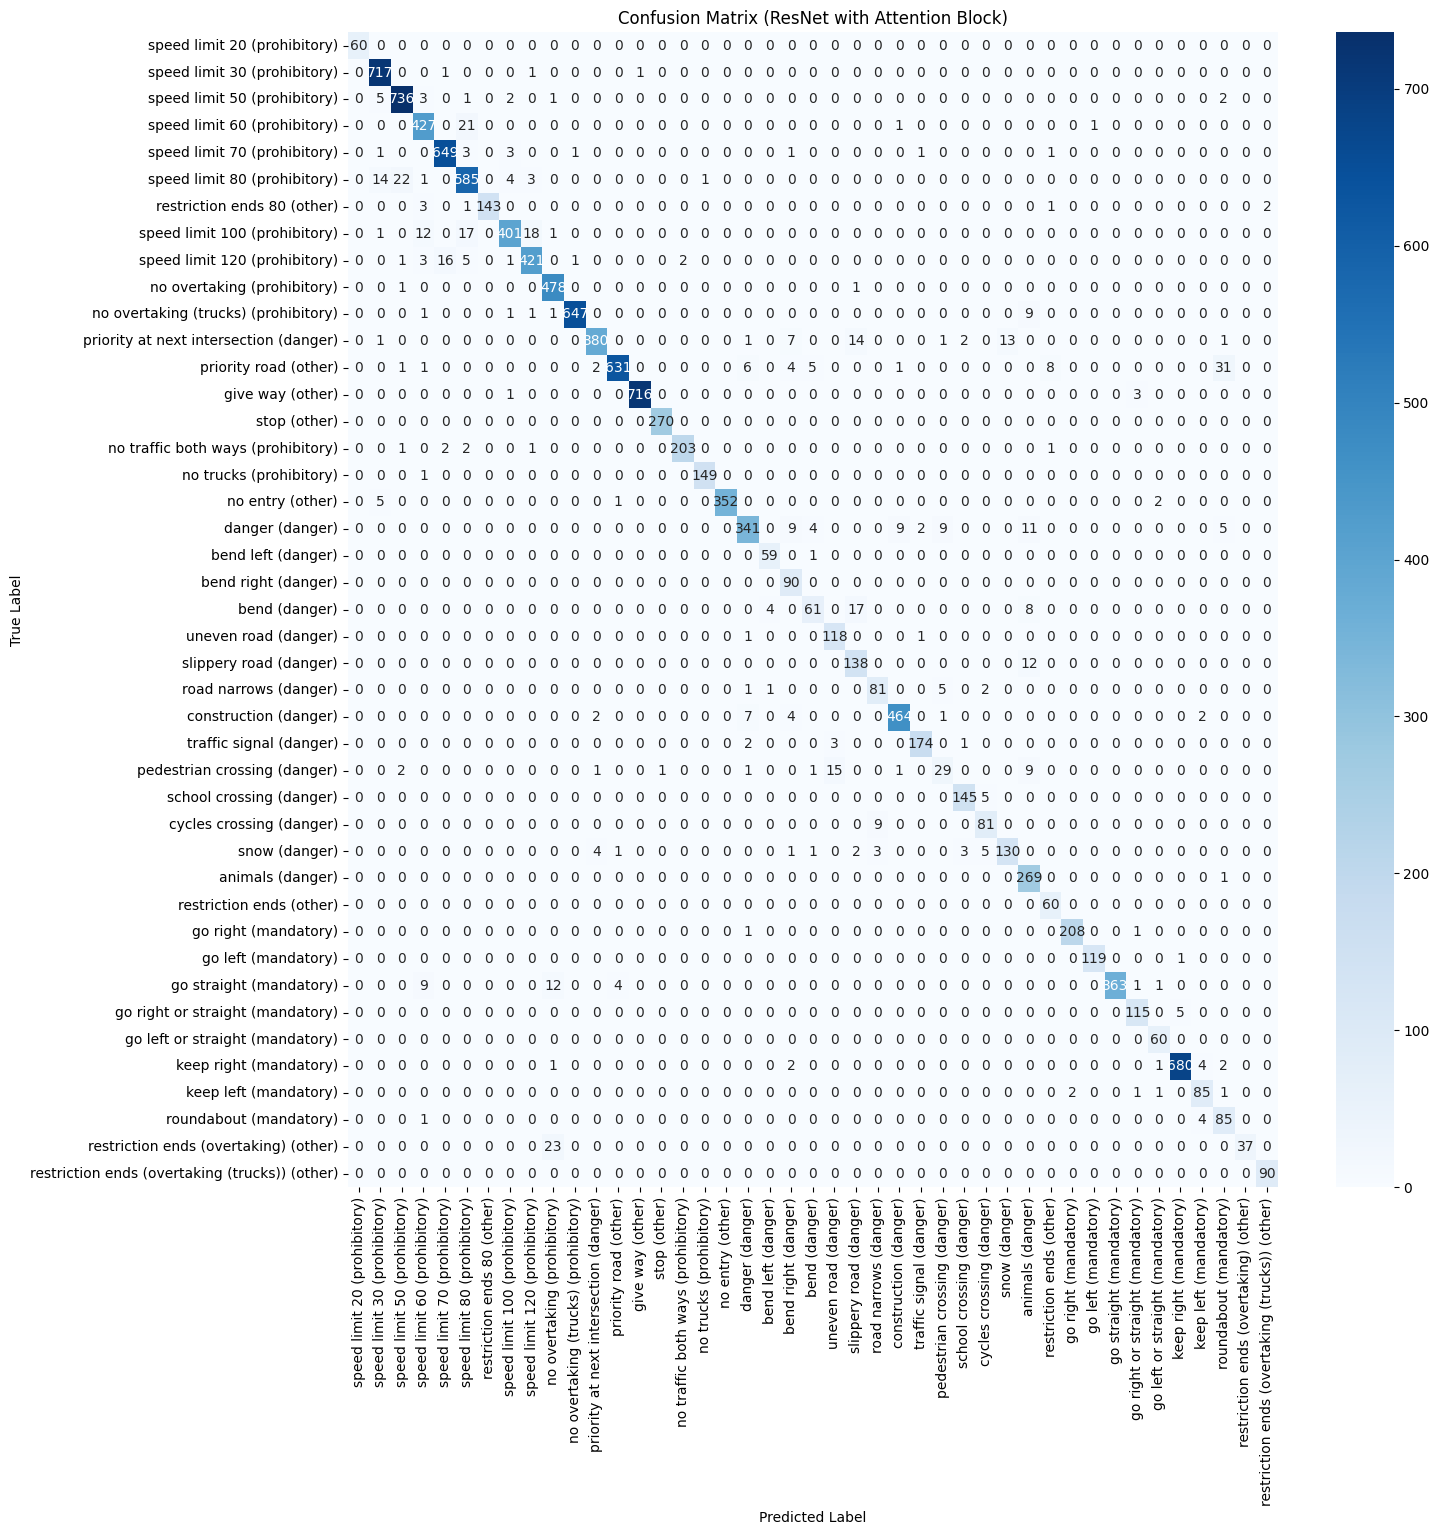

In [ ]:
# Generate confusion matrix for ResNet model with Attention Block
conf_matrix_resnet = confusion_matrix(y_test_true, y_test_pred_classes_resnet)

# Plot confusion matrix for ResNet model with Attention Block
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=class_id_to_name.values(), yticklabels=class_id_to_name.values())
plt.title('Confusion Matrix (ResNet with Attention Block)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


In [ ]:
# Calculate TP, FP, FN, TN for each class
FP, FN, TP, TN = calculate_metrics_per_class(conf_matrix_resnet)

metrics_df_resnet = pd.DataFrame({
    'Class': class_id_to_name.values(),
    'False Positive': FP,
    'False Negative': FN,
    'True Positive': TP,
    'True Negative': TN
})

print(metrics_df_resnet)


NameError: name 'calculate_metrics_per_class' is not defined

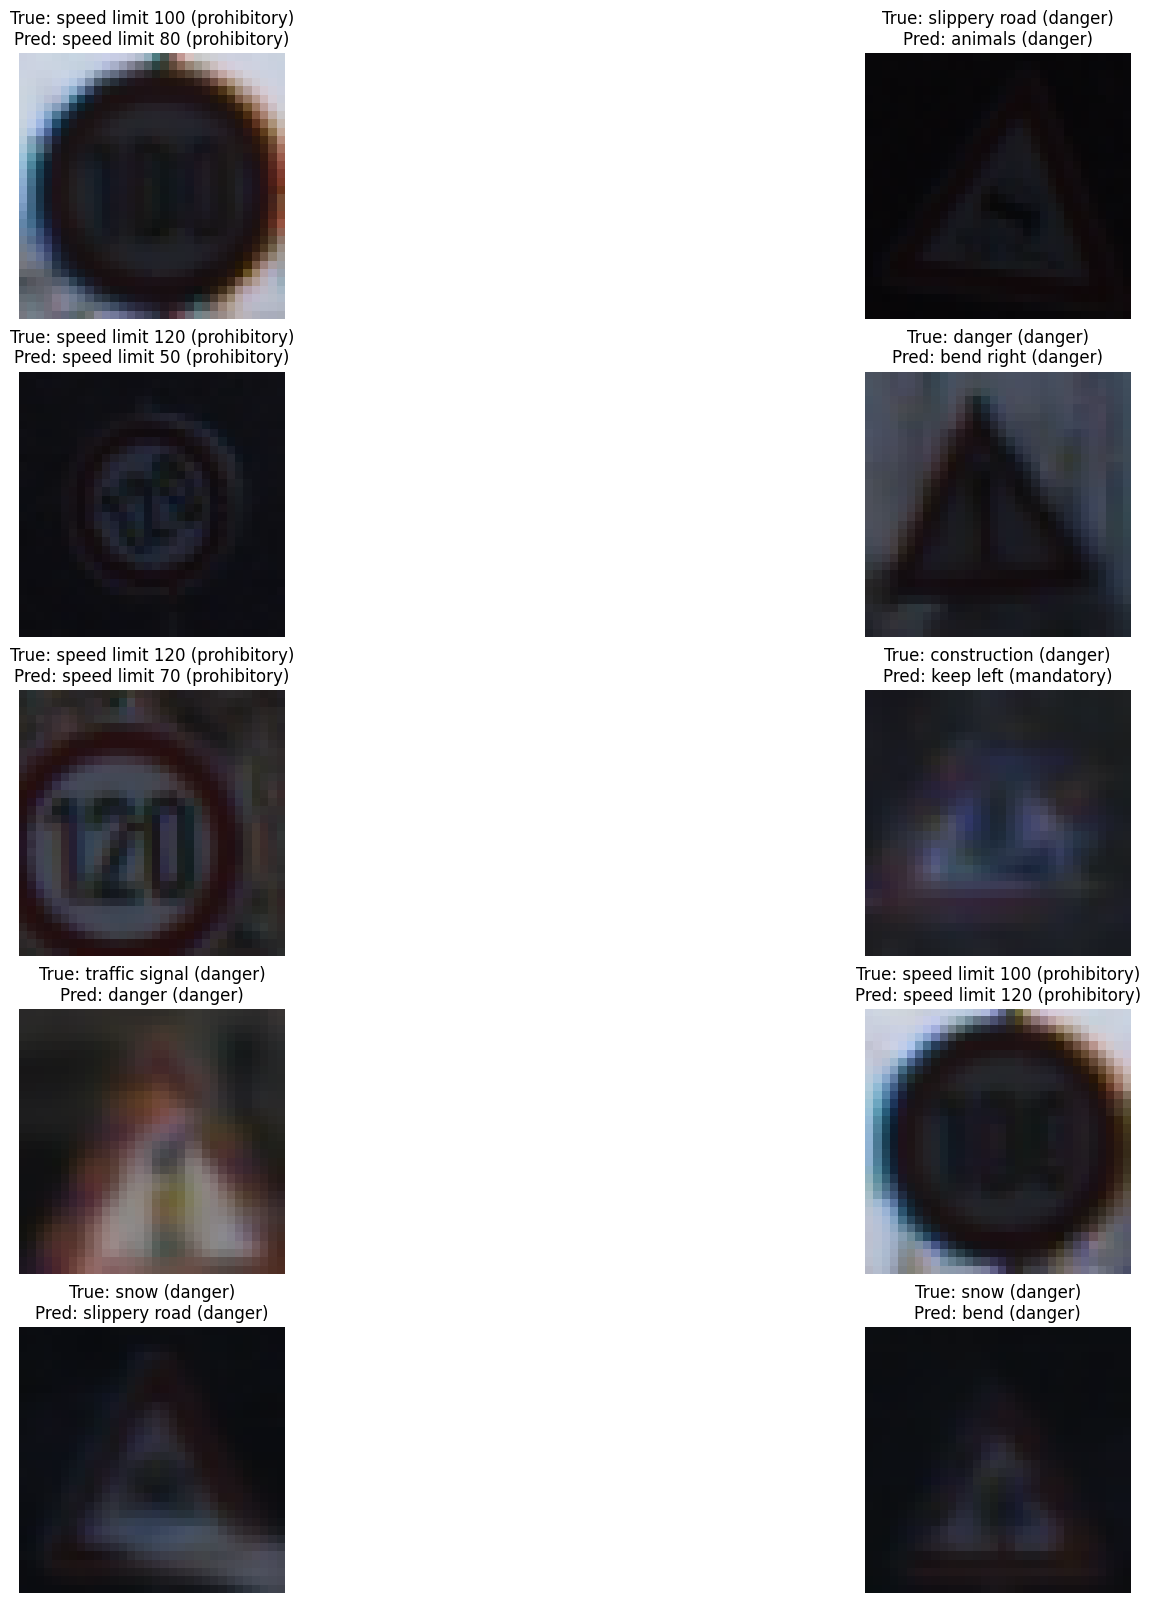

In [ ]:
# Show misclassified images with predictions and true classes for ResNet model with Attention Block
show_misclassified_images(test_images, y_test_true, y_test_pred_classes_resnet, class_id_to_name)


#VGGNet

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the VGGNet model
input_layer = Input(shape=(32, 32, 3))
vgg_base = VGG16(include_top=False, weights=None, input_tensor=input_layer)

x = Flatten()(vgg_base.output)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

vgg_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)


In [ ]:
# Define early stopping and model checkpoint callbacks
vgg_callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_vgg_model.h5', save_best_only=True)
]

# Train the VGGNet model
vgg_history = vgg_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=vgg_callbacks
)


Epoch 1/50
981/981 [==============================] - ETA: 0s - loss: 3.5255 - accuracy: 0.0541

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


981/981 [==============================] - 242s 244ms/step - loss: 3.5255 - accuracy: 0.0541 - val_loss: 3.4758 - val_accuracy: 0.0579
Epoch 2/50
981/981 [==============================] - 237s 241ms/step - loss: 3.4983 - accuracy: 0.0537 - val_loss: 3.4737 - val_accuracy: 0.0583
Epoch 3/50
981/981 [==============================] - 237s 241ms/step - loss: 3.4962 - accuracy: 0.0542 - val_loss: 3.4725 - val_accuracy: 0.0583
Epoch 4/50
981/981 [==============================] - 236s 240ms/step - loss: 3.4961 - accuracy: 0.0550 - val_loss: 3.4753 - val_accuracy: 0.0541
Epoch 5/50
981/981 [==============================] - 238s 242ms/step - loss: 3.4946 - accuracy: 0.0562 - val_loss: 3.4722 - val_accuracy: 0.0583
Epoch 6/50
981/981 [==============================] - 237s 241ms/step - loss: 3.4949 - accuracy: 0.0552 - val_loss: 3.4735 - val_accuracy: 0.0583
Epoch 7/50
981/981 [==============================] - 237s 241ms/step - loss: 3.4958 - accuracy: 0.0546 - val_loss: 3.4738 - val_accura

In [ ]:
# Predict on the test set
y_test_pred_vgg = vgg_model.predict(test_dataset)
y_test_pred_classes_vgg = np.argmax(y_test_pred_vgg, axis=1)

# Calculate accuracy for VGGNet model
test_accuracy_vgg = accuracy_score(y_test_true, y_test_pred_classes_vgg)
print(f'Test Accuracy (VGGNet): {test_accuracy_vgg:.4f}')

# Generate classification report for VGGNet model
class_report_vgg = classification_report(y_test_true, y_test_pred_classes_vgg, target_names=class_id_to_name.values())
print('Classification Report (VGGNet):')
print(class_report_vgg)


395/395 [==============================] - 18s 44ms/step
Test Accuracy (VGGNet): 0.0594
Classification Report (VGGNet):
                                                precision    recall  f1-score   support

                  speed limit 20 (prohibitory)       0.00      0.00      0.00        60
                  speed limit 30 (prohibitory)       0.00      0.00      0.00       720
                  speed limit 50 (prohibitory)       0.06      1.00      0.11       750
                  speed limit 60 (prohibitory)       0.00      0.00      0.00       450
                  speed limit 70 (prohibitory)       0.00      0.00      0.00       660
                  speed limit 80 (prohibitory)       0.00      0.00      0.00       630
                   restriction ends 80 (other)       0.00      0.00      0.00       150
                 speed limit 100 (prohibitory)       0.00      0.00      0.00       450
                 speed limit 120 (prohibitory)       0.00      0.00      0.00       450

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


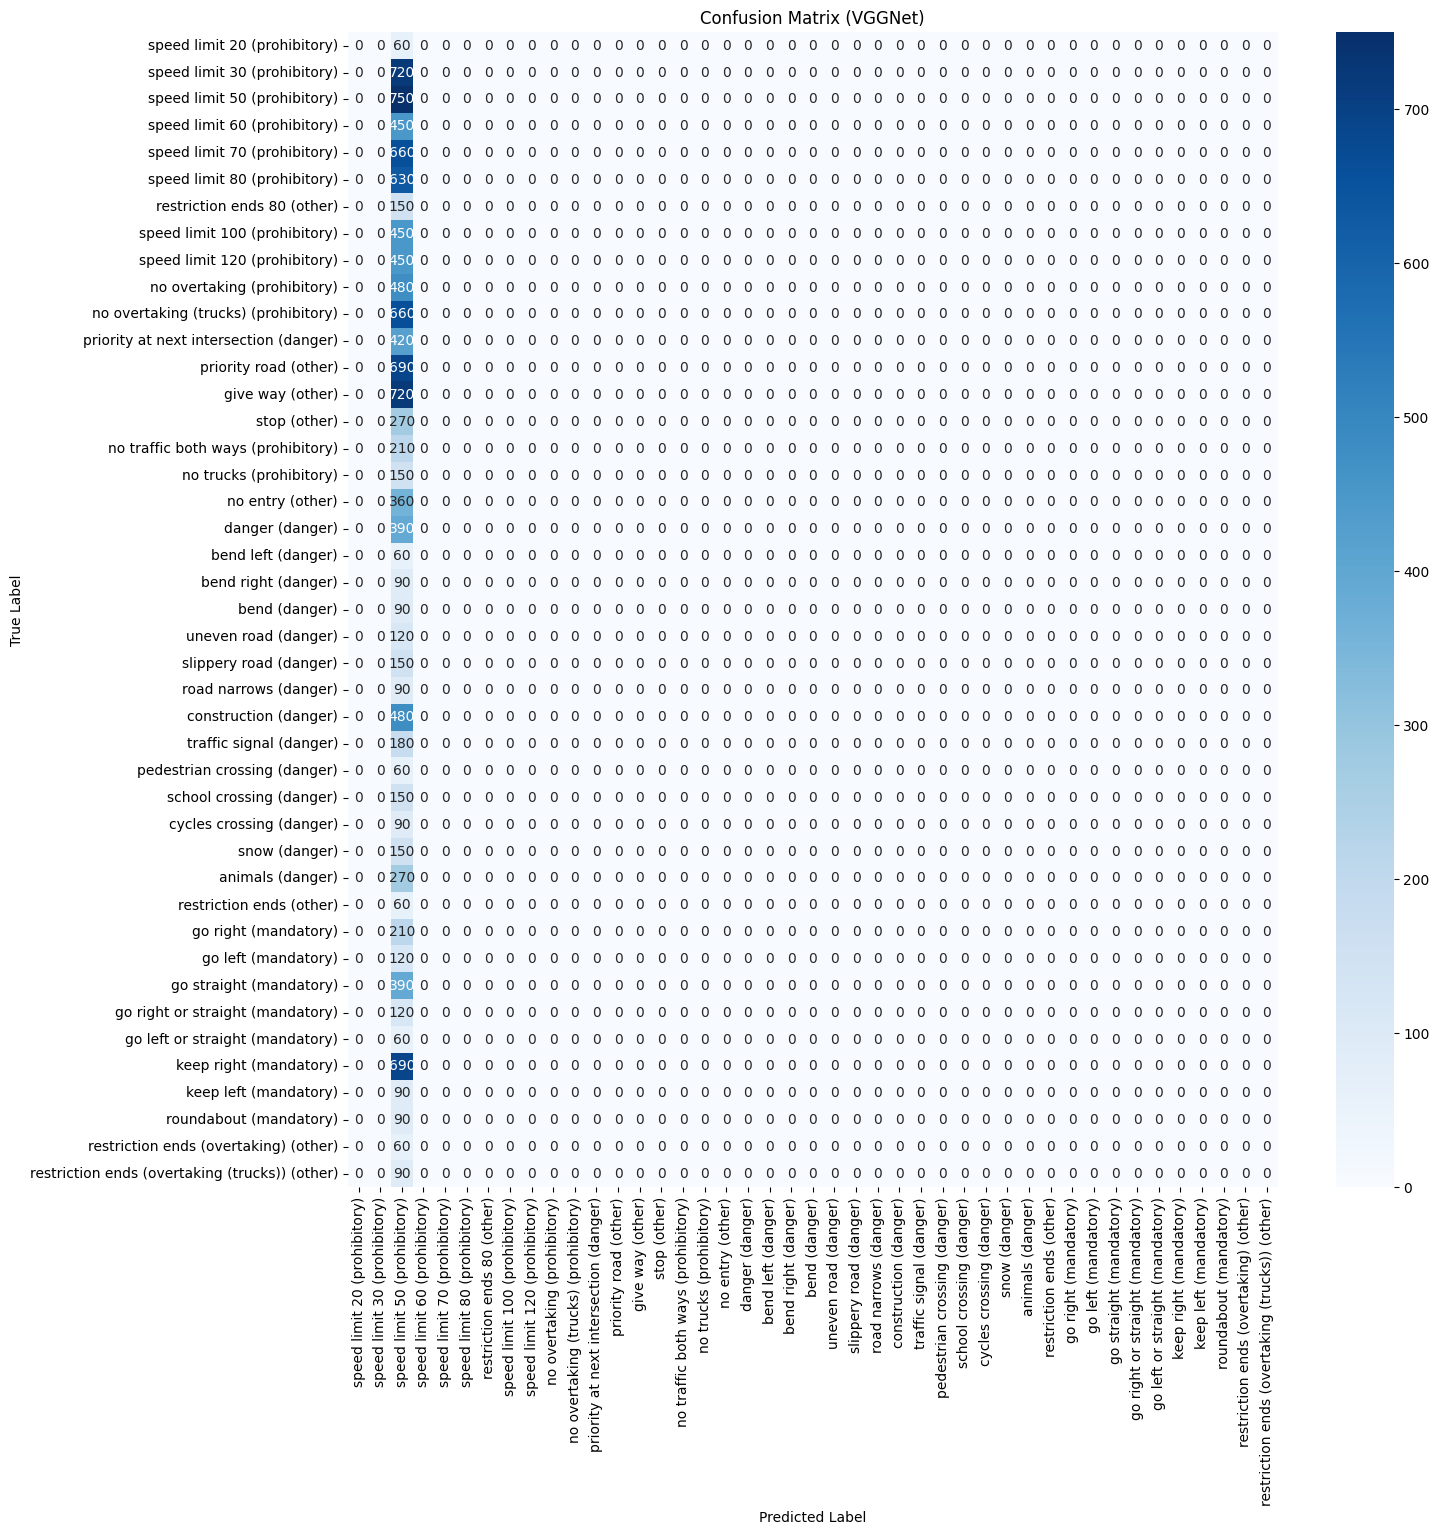

In [ ]:
# Generate confusion matrix for VGGNet model
conf_matrix_vgg = confusion_matrix(y_test_true, y_test_pred_classes_vgg)

# Plot confusion matrix for VGGNet model
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix_vgg, annot=True, fmt='d', cmap='Blues', xticklabels=class_id_to_name.values(), yticklabels=class_id_to_name.values())
plt.title('Confusion Matrix (VGGNet)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


#FINE TUNING VGGNET

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout

# Define the original VGGNet model
input_layer = Input(shape=(32, 32, 3))
vgg_base = VGG16(include_top=False, weights=None, input_tensor=input_layer)

x = Flatten()(vgg_base.output)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

vgg_model_original = Model(inputs=input_layer, outputs=output_layer)

# Print the summary of the original VGGNet model
vgg_model_original.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the input layer
input_layer = Input(shape=(32, 32, 3))

# Load the VGG16 model with pre-trained weights
vgg_base = VGG16(include_top=False, weights='imagenet', input_tensor=input_layer)

# Freeze all layers except the last block (block5) and the dense layers
for layer in vgg_base.layers:
    layer.trainable = False

for layer in vgg_base.layers[-4:]:  # Unfreeze the last convolutional block
    layer.trainable = True

# Add custom layers on top
x = Flatten()(vgg_base.output)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Create the model
vgg_model_finetuned = Model(inputs=input_layer, outputs=output_layer)

# Print the summary of the fine-tuned VGGNet model
vgg_model_finetuned.summary()

# Compile the fine-tuned model
vgg_model_finetuned.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

# Define early stopping and model checkpoint callbacks
vgg_callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_vgg_model_finetuned.h5', save_best_only=True)
]

# Train the fine-tuned VGGNet model
vgg_history = vgg_model_finetuned.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=25,
    callbacks=vgg_callbacks
)



Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


981/981 [==============================] - 166s 167ms/step - loss: 3.5171 - accuracy: 0.0545 - val_loss: 3.4874 - val_accuracy: 0.0606
Epoch 2/25
477/981 [=============>................] - ETA: 1:13 - loss: 3.5011 - accuracy: 0.0535

#MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the MobileNet model
input_layer = Input(shape=(32, 32, 3))
base_model = MobileNet(input_shape=(32, 32, 3), include_top=False, weights='imagenet')
x = base_model(input_layer, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

mobilenet_model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
mobilenet_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)


17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# Define early stopping and model checkpoint callbacks
mobilenet_callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_mobilenet_model.h5', save_best_only=True)
]

# Train the MobileNet model
mobilenet_history = mobilenet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=mobilenet_callbacks
)


Epoch 1/50
981/981 [==============================] - 60s 55ms/step - loss: 3.5671 - accuracy: 0.0505 - val_loss: 3.5050 - val_accuracy: 0.0583


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
981/981 [==============================] - 53s 54ms/step - loss: 3.5262 - accuracy: 0.0560 - val_loss: 3.4770 - val_accuracy: 0.0579
Epoch 3/50
981/981 [==============================] - 53s 54ms/step - loss: 3.5131 - accuracy: 0.0569 - val_loss: 3.4757 - val_accuracy: 0.0579
Epoch 4/50
981/981 [==============================] - 53s 54ms/step - loss: 3.5084 - accuracy: 0.0554 - val_loss: 3.4742 - val_accuracy: 0.0583
Epoch 5/50
981/981 [==============================] - 53s 54ms/step - loss: 3.5077 - accuracy: 0.0548 - val_loss: 3.4710 - val_accuracy: 0.0579
Epoch 6/50
981/981 [==============================] - 54s 54ms/step - loss: 3.4997 - accuracy: 0.0557 - val_loss: 3.4755 - val_accuracy: 0.0579
Epoch 7/50
981/981 [==============================] - 53s 54ms/step - loss: 3.4980 - accuracy: 0.0567 - val_loss: 3.4814 - val_accuracy: 0.0579
Epoch 8/50
981/981 [==============================] - 53s 53ms/step - loss: 3.4942 - accuracy: 0.0545 - val_loss: 3.4735 - val_accuracy:

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_test_pred_mobilenet = mobilenet_model.predict(test_dataset)
y_test_pred_classes_mobilenet = np.argmax(y_test_pred_mobilenet, axis=1)

# Calculate accuracy for MobileNet model
test_accuracy_mobilenet = accuracy_score(y_test_true, y_test_pred_classes_mobilenet)
print(f'Test Accuracy (MobileNet): {test_accuracy_mobilenet:.4f}')

# Generate classification report for MobileNet model
class_report_mobilenet = classification_report(y_test_true, y_test_pred_classes_mobilenet, target_names=class_id_to_name.values())
print('Classification Report (MobileNet):')
print(class_report_mobilenet)


395/395 [==============================] - 7s 16ms/step
Test Accuracy (MobileNet): 0.0594
Classification Report (MobileNet):
                                                precision    recall  f1-score   support

                  speed limit 20 (prohibitory)       0.00      0.00      0.00        60
                  speed limit 30 (prohibitory)       0.00      0.00      0.00       720
                  speed limit 50 (prohibitory)       0.06      1.00      0.11       750
                  speed limit 60 (prohibitory)       0.00      0.00      0.00       450
                  speed limit 70 (prohibitory)       0.00      0.00      0.00       660
                  speed limit 80 (prohibitory)       0.00      0.00      0.00       630
                   restriction ends 80 (other)       0.00      0.00      0.00       150
                 speed limit 100 (prohibitory)       0.00      0.00      0.00       450
                 speed limit 120 (prohibitory)       0.00      0.00      0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


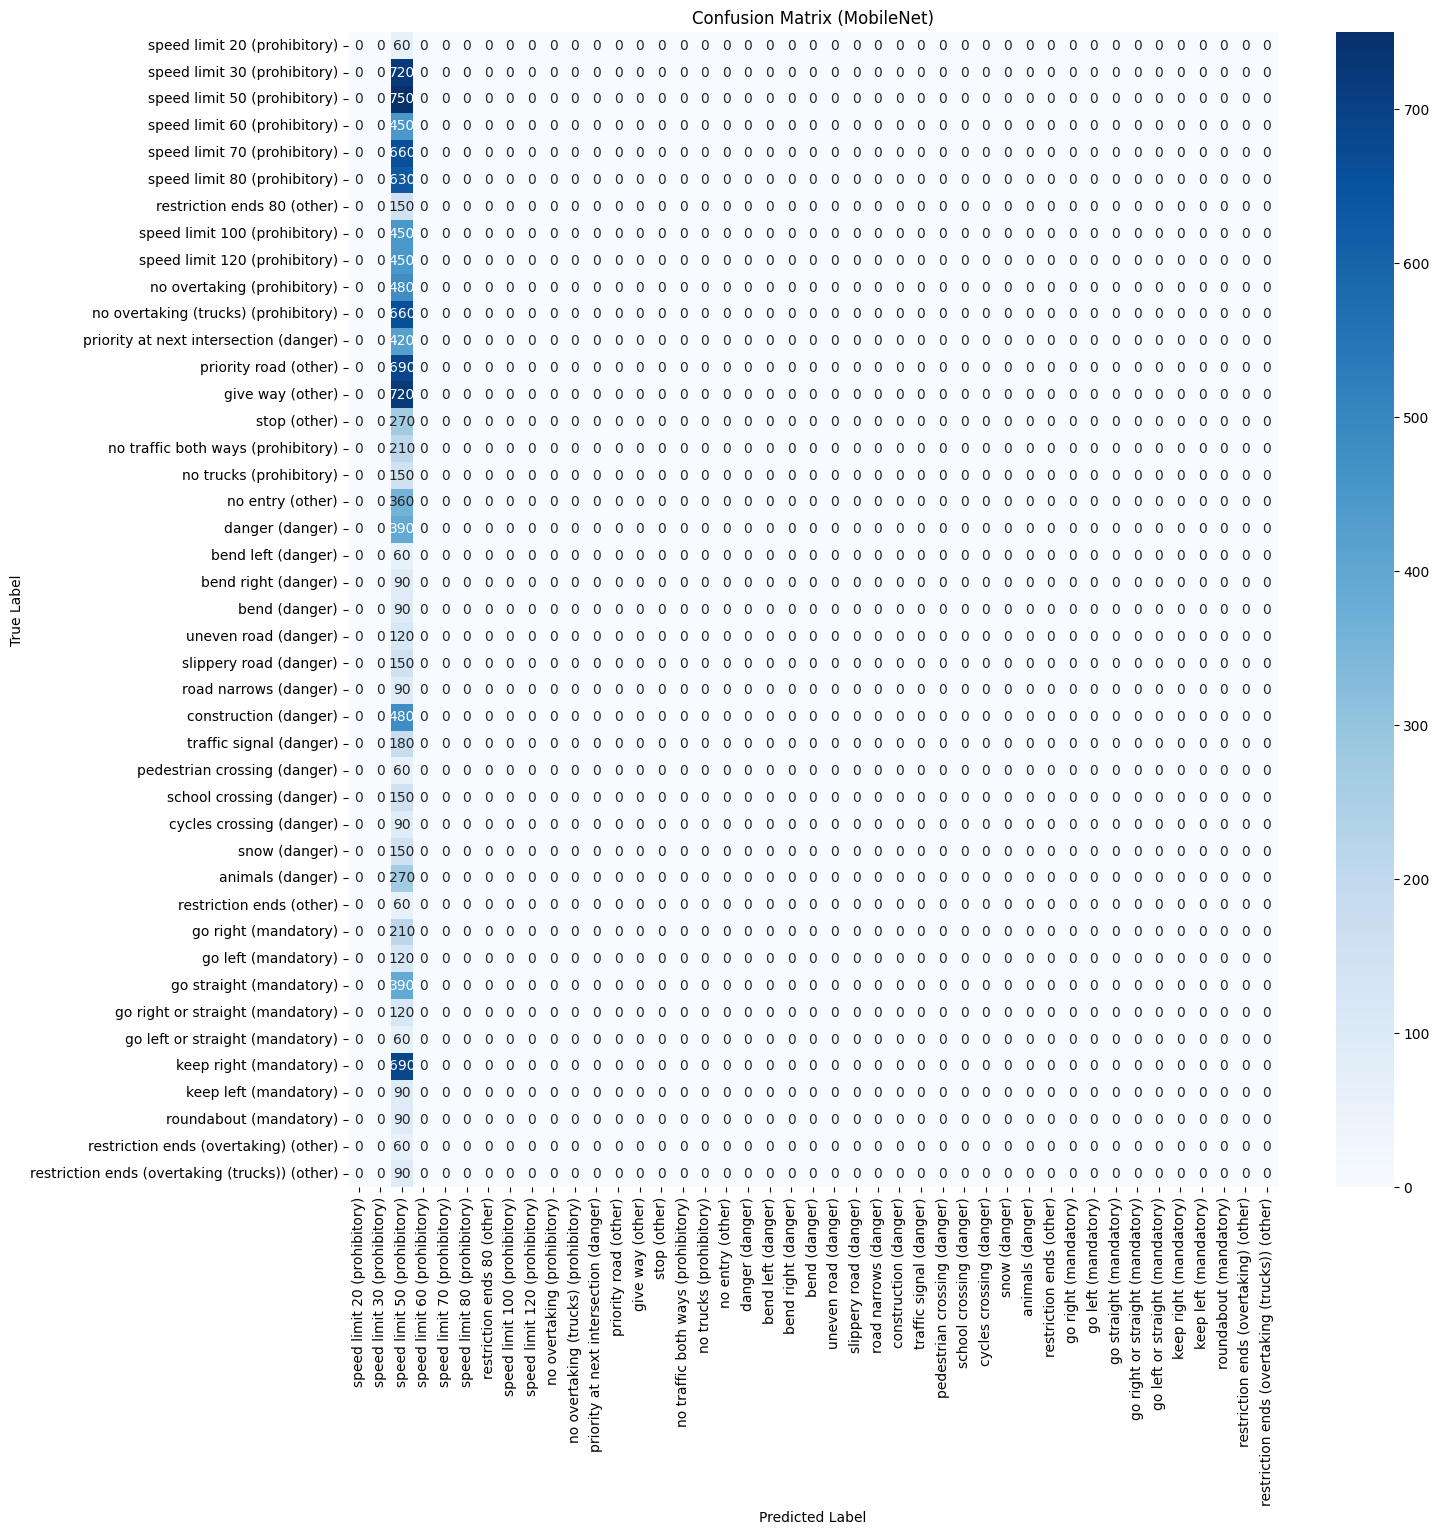

In [ ]:
# Generate confusion matrix for MobileNet model
conf_matrix_mobilenet = confusion_matrix(y_test_true, y_test_pred_classes_mobilenet)

# Plot confusion matrix for MobileNet model
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix_mobilenet, annot=True, fmt='d', cmap='Blues', xticklabels=class_id_to_name.values(), yticklabels=class_id_to_name.values())
plt.title('Confusion Matrix (MobileNet)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


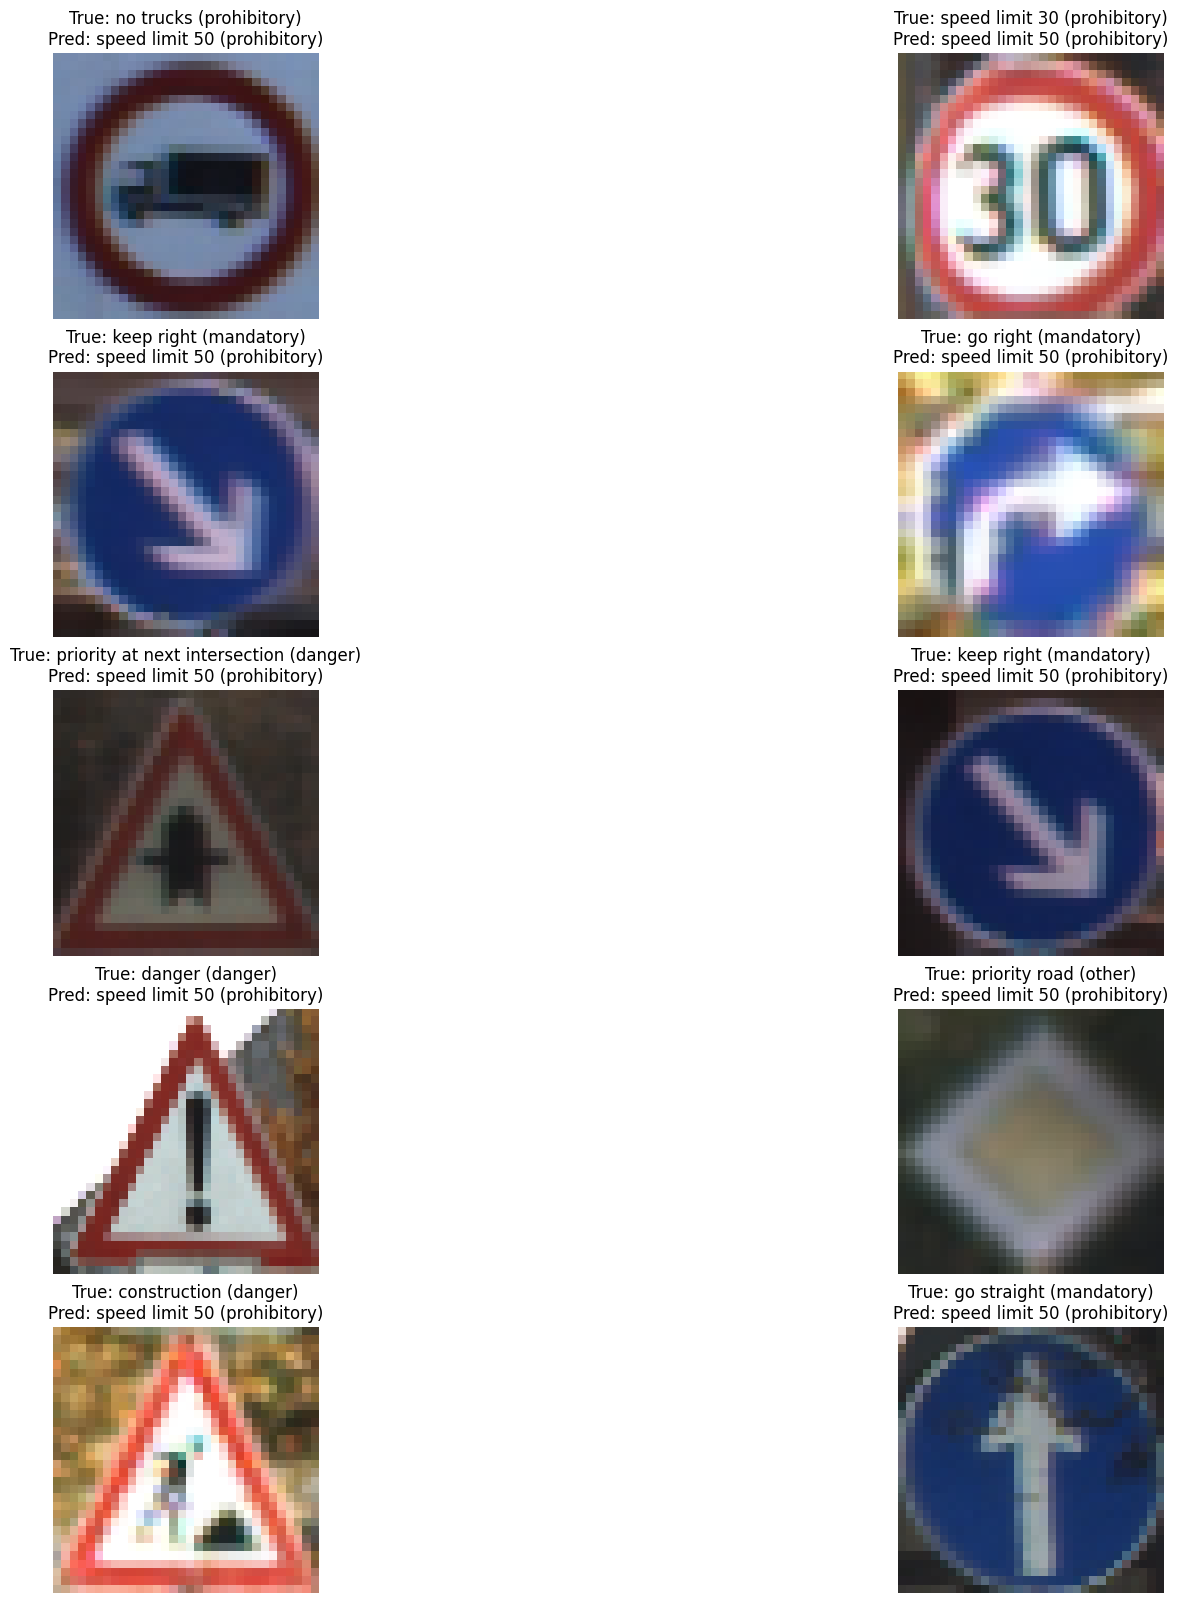

In [ ]:
# Function to show misclassified images
def show_misclassified_images(images, true_labels, pred_labels, class_names, num_images=10):
    misclassified_indices = np.where(true_labels != pred_labels)[0]
    plt.figure(figsize=(20, 20))
    for i, idx in enumerate(misclassified_indices[:num_images]):
        plt.subplot(5, 2, i + 1)
        plt.imshow(images[idx])
        true_class = class_names[true_labels[idx]]
        pred_class = class_names[pred_labels[idx]]
        plt.title(f'True: {true_class}\nPred: {pred_class}')
        plt.axis('off')
    plt.show()

# Prepare data for visualization
# As the dataset is batched, we need to convert it back to arrays for visualization
test_images_list = list(test_dataset.as_numpy_iterator())
test_images = np.concatenate([batch[0] for batch in test_images_list])
test_labels = np.concatenate([batch[1] for batch in test_images_list])

# Class names
class_names = [class_id_to_name[i] for i in range(num_classes)]

# Show misclassified images
show_misclassified_images(test_images, y_test_true, y_test_pred_classes_mobilenet, class_names)


REalizamos finetunning

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the MobileNet model with correct input size and normalization
input_layer = Input(shape=(32, 32, 3))
base_model = MobileNet(input_shape=(32, 32, 3), include_top=False, weights='imagenet')
x = base_model(input_layer, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

mobilenet_model = Model(inputs=input_layer, outputs=output_layer)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last 20 layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile the model
mobilenet_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)


In [ ]:
# Define early stopping and model checkpoint callbacks
mobilenet_callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_mobilenet_finetuned_model.h5', save_best_only=True)
]

# Train the MobileNet model with fine-tuning
mobilenet_history = mobilenet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=mobilenet_callbacks
)


Epoch 1/50
981/981 [==============================] - 33s 31ms/step - loss: 2.8230 - accuracy: 0.2273 - val_loss: 1.9968 - val_accuracy: 0.4105
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


981/981 [==============================] - 30s 30ms/step - loss: 1.9205 - accuracy: 0.4178 - val_loss: 1.5428 - val_accuracy: 0.5194
Epoch 3/50
981/981 [==============================] - 29s 30ms/step - loss: 1.5799 - accuracy: 0.5032 - val_loss: 1.3040 - val_accuracy: 0.5497
Epoch 4/50
981/981 [==============================] - 30s 30ms/step - loss: 1.3626 - accuracy: 0.5594 - val_loss: 1.1184 - val_accuracy: 0.6335
Epoch 5/50
981/981 [==============================] - 30s 30ms/step - loss: 1.1834 - accuracy: 0.6148 - val_loss: 0.9689 - val_accuracy: 0.6695
Epoch 6/50
981/981 [==============================] - 30s 30ms/step - loss: 1.0671 - accuracy: 0.6458 - val_loss: 0.9090 - val_accuracy: 0.6904
Epoch 7/50
981/981 [==============================] - 30s 30ms/step - loss: 0.9599 - accuracy: 0.6794 - val_loss: 0.8263 - val_accuracy: 0.7251
Epoch 8/50
981/981 [==============================] - 30s 30ms/step - loss: 0.8901 - accuracy: 0.7070 - val_loss: 0.7604 - val_accuracy: 0.7460
Epo

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_test_pred_mobilenet = mobilenet_model.predict(test_dataset)
y_test_pred_classes_mobilenet = np.argmax(y_test_pred_mobilenet, axis=1)

# Calculate accuracy for MobileNet model
test_accuracy_mobilenet = accuracy_score(y_test_true, y_test_pred_classes_mobilenet)
print(f'Test Accuracy (MobileNet with Fine-Tuning): {test_accuracy_mobilenet:.4f}')

# Generate classification report for MobileNet model
class_report_mobilenet = classification_report(y_test_true, y_test_pred_classes_mobilenet, target_names=class_id_to_name.values())
print('Classification Report (MobileNet with Fine-Tuning):')
print(class_report_mobilenet)


395/395 [==============================] - 7s 16ms/step
Test Accuracy (MobileNet with Fine-Tuning): 0.7812
Classification Report (MobileNet with Fine-Tuning):
                                                precision    recall  f1-score   support

                  speed limit 20 (prohibitory)       0.75      0.05      0.09        60
                  speed limit 30 (prohibitory)       0.86      0.60      0.71       720
                  speed limit 50 (prohibitory)       0.61      0.79      0.69       750
                  speed limit 60 (prohibitory)       0.77      0.59      0.67       450
                  speed limit 70 (prohibitory)       0.72      0.85      0.78       660
                  speed limit 80 (prohibitory)       0.62      0.67      0.64       630
                   restriction ends 80 (other)       0.91      0.85      0.88       150
                 speed limit 100 (prohibitory)       0.79      0.74      0.76       450
                 speed limit 120 (prohibitory)  

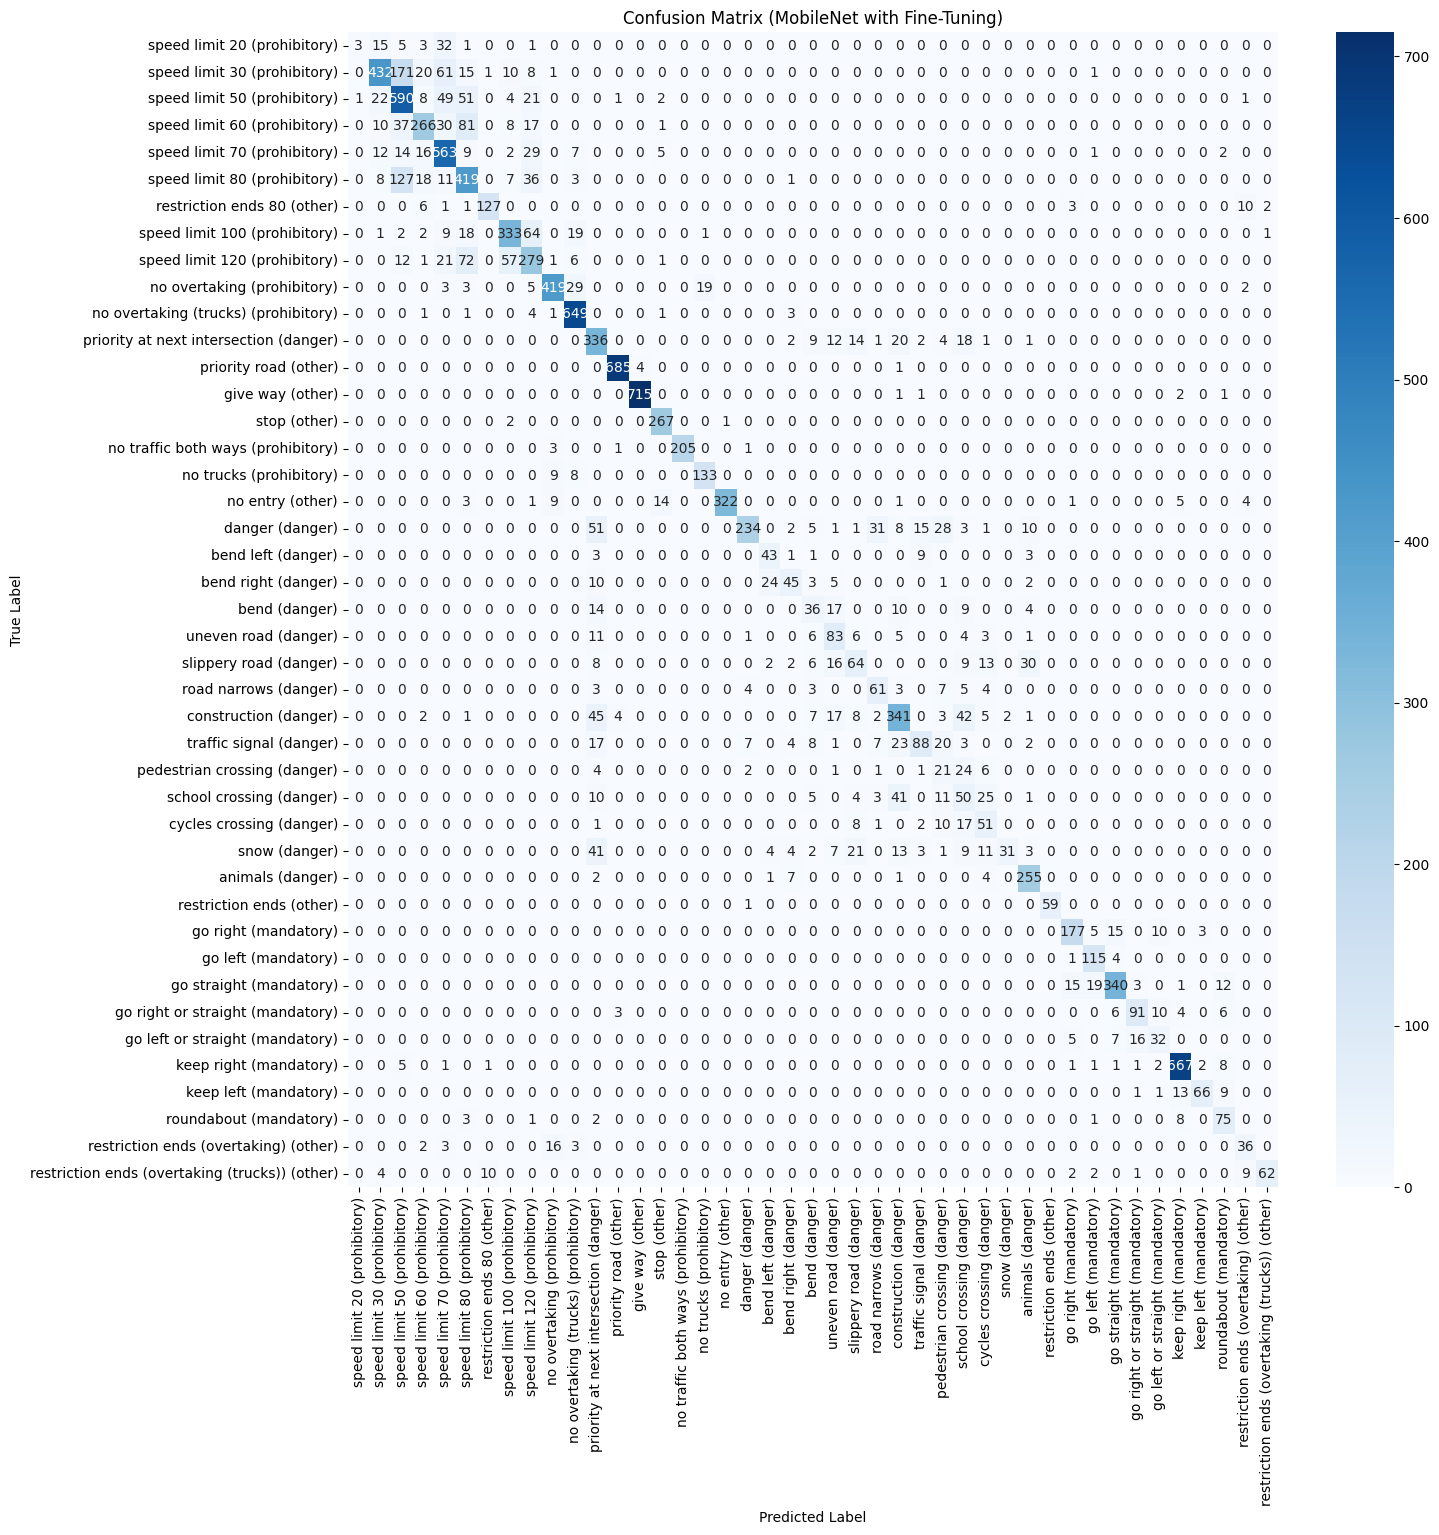

In [ ]:
# Generate confusion matrix for MobileNet model with fine-tuning
conf_matrix_mobilenet = confusion_matrix(y_test_true, y_test_pred_classes_mobilenet)

# Plot confusion matrix for MobileNet model with fine-tuning
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix_mobilenet, annot=True, fmt='d', cmap='Blues', xticklabels=class_id_to_name.values(), yticklabels=class_id_to_name.values())
plt.title('Confusion Matrix (MobileNet with Fine-Tuning)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()
